# Rossmann Project - Análise Exploratória de Dados

Fonte: https://www.kaggle.com/competitions/rossmann-store-sales

## Importação de bibliotecas

In [1]:
import math
import pandas as pd
import random
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
import random
import pickle
import warnings


from scipy import stats as ss
from IPython.display import Image
from IPython.core.display import HTML


from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

warnings.filterwarnings('ignore')

In [2]:
def jupyter_settings():
    %matplotlib inline
#     %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

## Carregando os dados

In [4]:
# low_memory = False (ler todo o arquivo na mesma hora coloca na memoria)
df_sales_raw = pd.read_csv ('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv ('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
# VERIFICAR SE HÁ LINHAS DUPLICADAS
df_raw[df_raw.duplicated(keep=False)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


## Descrição dos dados

In [6]:
df1 = df_raw.copy()

In [7]:
df1.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
545860,296,4,2014-02-27,6209,740,1,0,0,0,a,a,9580.0,5.0,2007.0,1,45.0,2014.0,"Feb,May,Aug,Nov"
191634,970,2,2015-02-10,3172,432,1,0,0,0,a,a,910.0,12.0,2014.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
586177,473,3,2014-01-22,4151,559,1,1,0,0,a,a,50.0,NaN,NaN,0,NaN,NaN,NaN
587704,885,2,2014-01-21,5851,706,1,1,0,0,a,a,480.0,12.0,2005.0,0,NaN,NaN,NaN
839725,916,7,2013-06-09,0,0,0,0,0,0,a,a,90.0,11.0,2012.0,0,NaN,NaN,NaN


**Renomeando as colunas**

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename columns
df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

**Descrição das colunas**


colunas | descrição
------- | ---------
store | um ID único para cada loja
day_of_week | o dia da semana
date | data do registro
sales | o volume de negócios para qualquer dia (é isso que você está prevendo)
customers | o número de clientes em um determinado dia
open | um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto
promo | indica se uma loja está realizando uma promoção naquele dia
state_holiday | feriado estadual. a = feriado, b = feriado da Páscoa, c = Natal, 0 = nenhum
school_holiday | indica se a (Loja, Data) foi afetada pelo fechamento das escolas públicas
store_type | diferencia entre 4 modelos de lojas diferentes: a, b, c, d
assortment | descreve um nível de sortimento: a = básico, b = extra, c = estendido
competition_distance | distância em metros até a loja concorrente mais próxima
competition_open_since_month | indica o mês aproximados em que o concorrente mais próximo foi aberto
competition_open_since_year | indica o ano aproximados em que o concorrente mais próximo foi aberto
promo2 | promoção contínua e consecutiva para algumas lojas: 0 = não está participando, 1 = participando
promo2_since_week | descreve a semana em que a loja começou a participar do Promo2
promo2_since_year | descreve o ano em que a loja começou a participar do Promo2
promo_interval | descreve os intervalos consecutivos em que o Promo2 é iniciado


**Dimensão do dataset**

In [10]:
print(f'Total de linhas: {df1.shape[0]}')
print(f'Total de colunas: {df1.shape[1]}')

Total de linhas: 1017209
Total de colunas: 18


**Tipos das variáveis**

In [11]:
# mudar o types da coluna date
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

**Valores ausentes**

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

**Fillout NA**

In [13]:
#competition_distance - distancia em metros da loja competidora proxima
    # uma das formas de eliminar os NAs é preenchendo as linhas faltantes
    # utilizando a lógica de que talvez  NA é pq a loja competidora está bem distante
    # e para isso irei preencher um valor qualquer 200000.0 (maior q o valor maximo do meu dataframe) 
    
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month - mes/ano que a loja competidora foi aberta
# quando é mais de uma coluna coloca axis=1
# foi preenchido de acordo com a data de registro
    
df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month 
                                               if math.isnan(x['competition_open_since_month']) else 
                                               x['competition_open_since_month'], axis=1)

#competition_open_since_year  
df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year 
                                               if math.isnan(x['competition_open_since_year']) else      
                                               x['competition_open_since_year'], axis=1)                       
#promo2_since_week
df1['promo2_since_week']= df1.apply(lambda x: x['date'].week 
                                               if math.isnan(x['promo2_since_week']) else      
                                               x['promo2_since_week'], axis=1)  
#promo2_since_year   
df1['promo2_since_year']= df1.apply(lambda x: x['date'].year 
                                               if math.isnan(x['promo2_since_year']) else      
                                               x['promo2_since_year'], axis=1)


df1['promo_interval'] = df1['promo_interval'].fillna(0)

**Change Types**

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

**Descrição Estatística**

In [15]:
# changes behavior globaly in Jupyter Notebooks
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [16]:
# algumas descrições estatísticas 
df1.describe()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year
count,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000
mean,558.42973,3.99834,5773.81897,633.14595,0.83011,0.38151,0.17865,5935.44268,6.78685,2010.32484,0.50056,23.61903,2012.79330
std,321.90865,1.99739,3849.92618,464.41173,0.37554,0.48576,0.38306,12547.65300,3.31109,5.51559,0.50000,14.31006,1.66266
min,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,20.00000,1.00000,1900.00000,0.00000,1.00000,2009.00000
25%,280.00000,2.00000,3727.00000,405.00000,1.00000,0.00000,0.00000,710.00000,4.00000,2008.00000,0.00000,12.00000,2012.00000
50%,558.00000,4.00000,5744.00000,609.00000,1.00000,0.00000,0.00000,2330.00000,7.00000,2012.00000,1.00000,22.00000,2013.00000
75%,838.00000,6.00000,7856.00000,837.00000,1.00000,1.00000,0.00000,6910.00000,10.00000,2014.00000,1.00000,37.00000,2014.00000
max,1115.00000,7.00000,41551.00000,7388.00000,1.00000,1.00000,1.00000,200000.00000,12.00000,2015.00000,1.00000,52.00000,2015.00000


In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [18]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T
                  
# cocantenação dos dataframes
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00000,1115.00000,1114.00000,558.42973,558.00000,321.90849,-0.00095,-1.20052
1,day_of_week,1.00000,7.00000,6.00000,3.99834,4.00000,1.99739,0.00159,-1.24687
2,sales,0.00000,41551.00000,41551.00000,5773.81897,5744.00000,3849.92428,0.64146,1.77837
3,customers,0.00000,7388.00000,7388.00000,633.14595,609.00000,464.41151,1.59865,7.09177
4,open,0.00000,1.00000,1.00000,0.83011,1.00000,0.37554,-1.75804,1.09072
5,promo,0.00000,1.00000,1.00000,0.38151,0.00000,0.48576,0.48784,-1.76202
6,school_holiday,0.00000,1.00000,1.00000,0.17865,0.00000,0.38306,1.67784,0.81515
7,competition_distance,20.00000,200000.00000,199980.00000,5935.44268,2330.00000,12547.64683,10.24234,147.78971
8,competition_open_since_month,1.00000,12.00000,11.00000,6.78685,7.00000,3.31109,-0.04208,-1.23261
9,competition_open_since_year,1900.00000,2015.00000,115.00000,2010.32484,2012.00000,5.51559,-7.23566,124.07130


In [19]:
# Variáveis categóricas
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

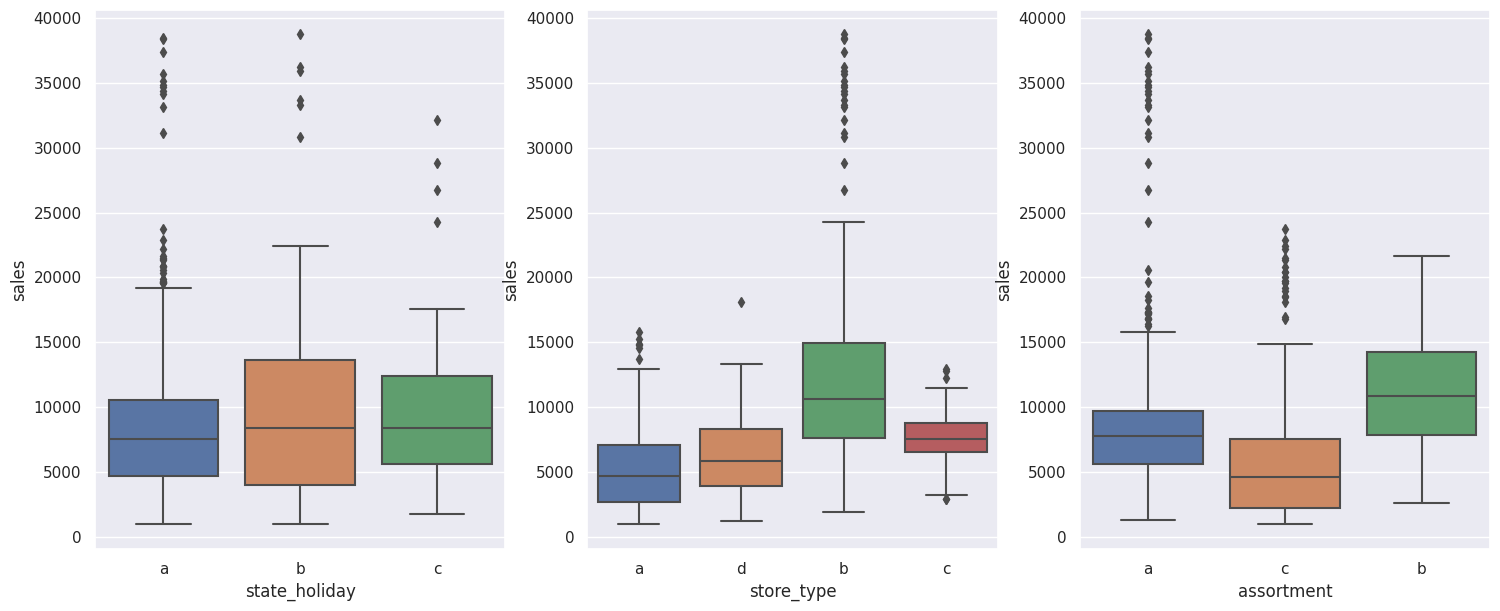

In [20]:
plt.figure(figsize=(18,7))
# filtrar o dataset
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales', data=aux);

## Feature Engineering

In [21]:
df2 = df1.copy()

In [22]:
## extraindo novas features da coluna date
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

## features de competition
# competition since - juntas o mes - ano
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'] , day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

## feature de promo
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# transformando em datetime
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

## feature assortment
df2['assortment']= df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 


# -----------------------------------------------------------------------------------------------------

#promo_interval - intervalos consecutivos quando a promo2 foi iniciada
# dicionario indicando o numero dos meses
month_map = {1: 'Jan',
            2: 'Feb',
            3: 'Mar',
            4: 'Apr',
            5: 'May',
            6: 'Jun',
            7: 'Jul',
            8: 'Aug',
            9: 'Sept',
            10: 'Oct',
            11: 'Nov',
            12: 'Dec'}

    # assumption: criadno uma coluna onde indica o mes da coluna date     
df2['month_map'] = df2['date'].dt.month.map(month_map)

    # assumption: se o mes estiver presente na coluna 'promo_interval' logo tem promocao ativa naquela data 
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 
                                                            1 if x['month_map'] in x['promo_interval'].split(',') 
                                                            else 0, axis=1)

**Seleção e Filtragem do Dataset**

In [23]:
df3 = df2.copy()

In [24]:
# as restrições observadas para o negócio foram loja fechada e vendas nulas
df3 = df3[(df3['open'] != 0) & (df3['sales'] != 0 )]

In [25]:
# a coluna customers é uma restrição para o modelo, pois tem essa informação daqui 6 semanas
# a não ser que eu faça outro modelo de previsão para calcular a coluna customers daqui 6 semanas.
# então por isso, foi retirar essa coluna do meu dataset para fazer a predição de vendas daqui 6 semanas.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

## Análise Exploratória 

In [26]:
df4 = df3.copy()

#### **Univariada**

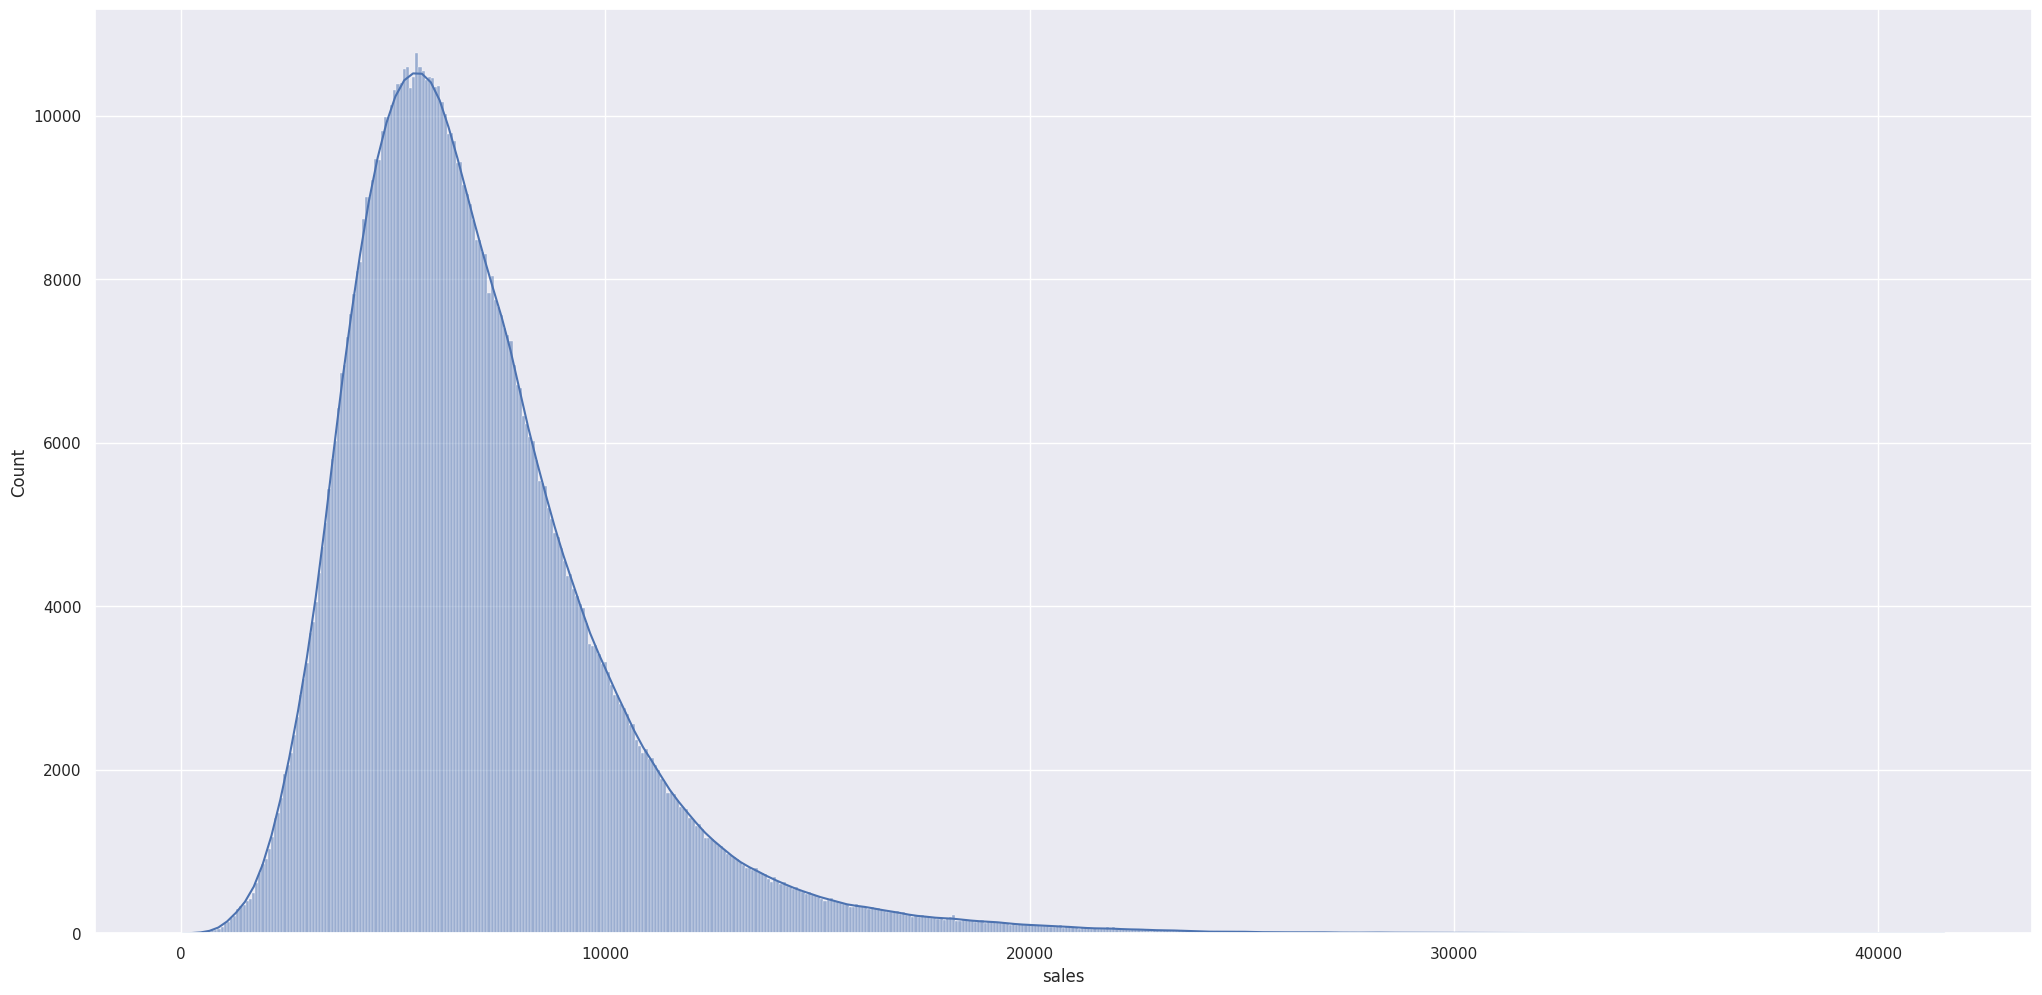

In [27]:
# a minha variavel resposavel pelo fenomeno é a coluna 'sales'
sns.histplot(df4['sales'], kde=True);

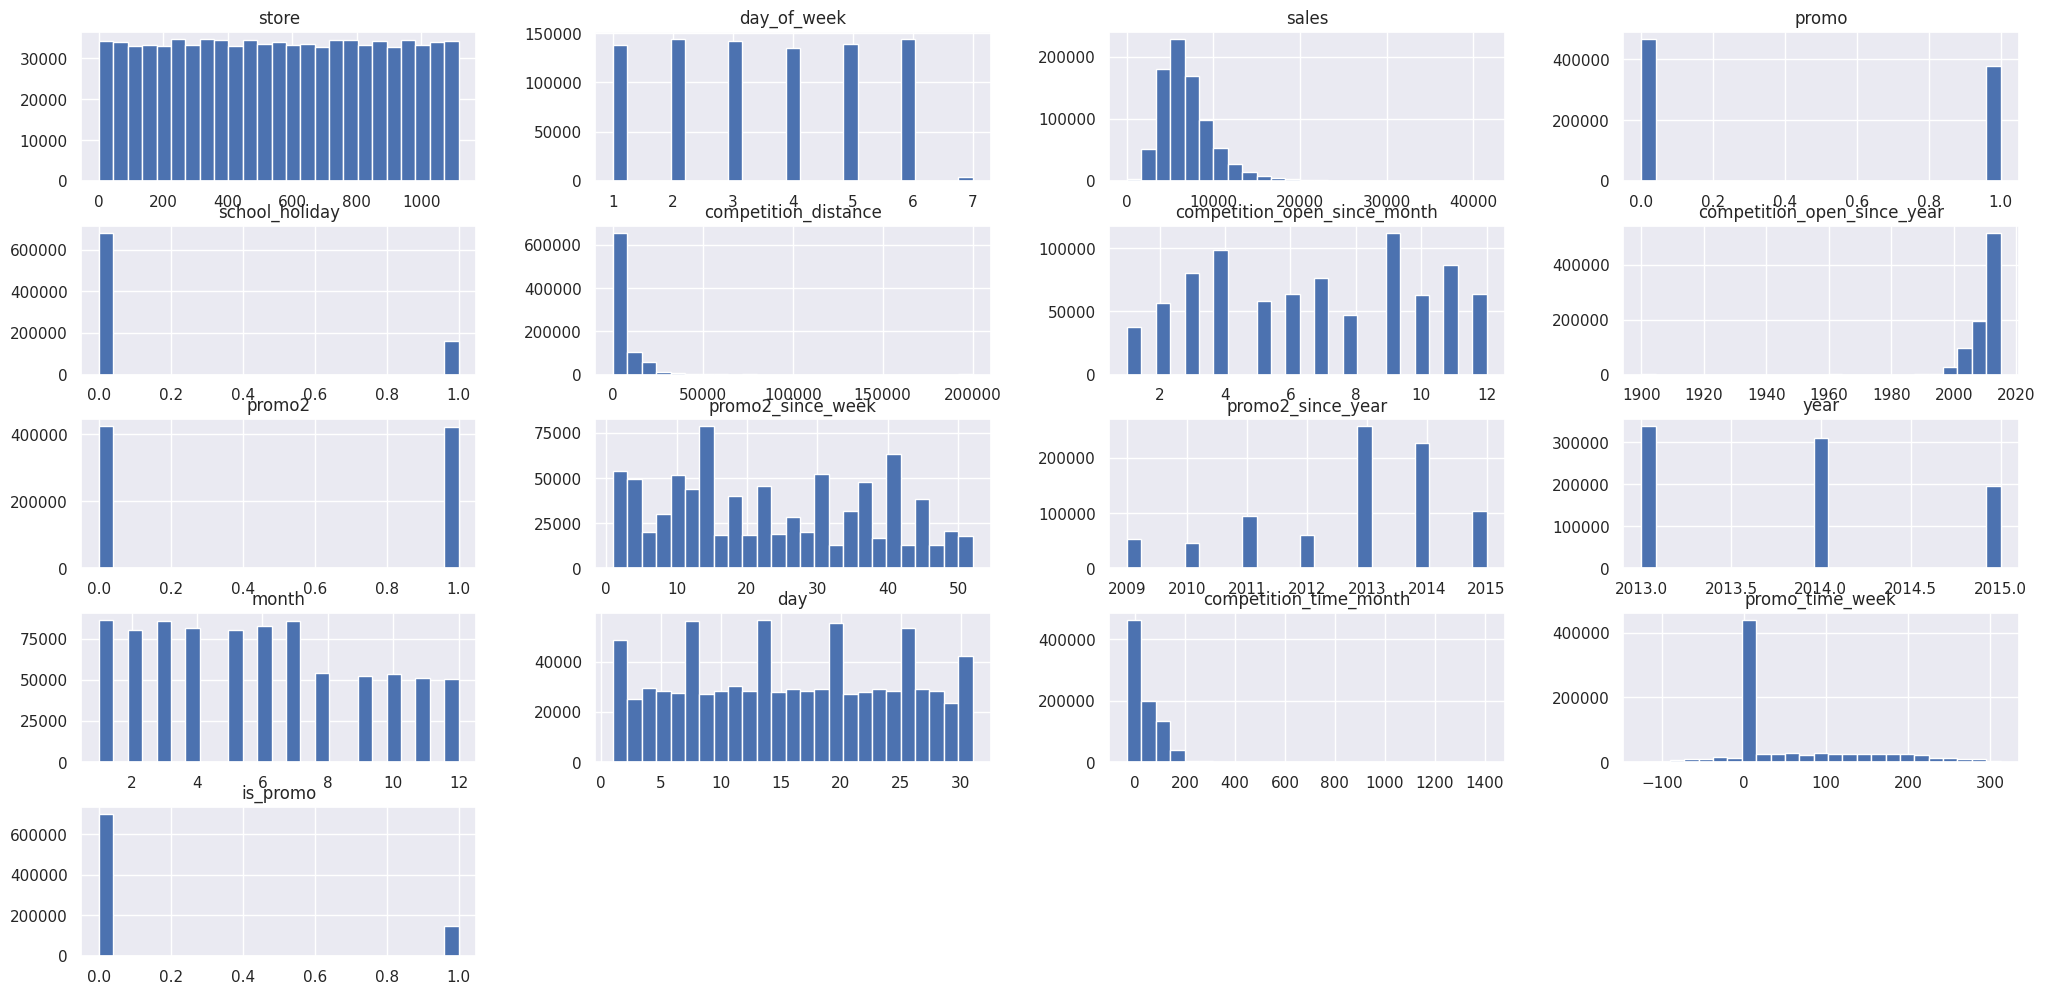

In [28]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(bins=25);

In [29]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

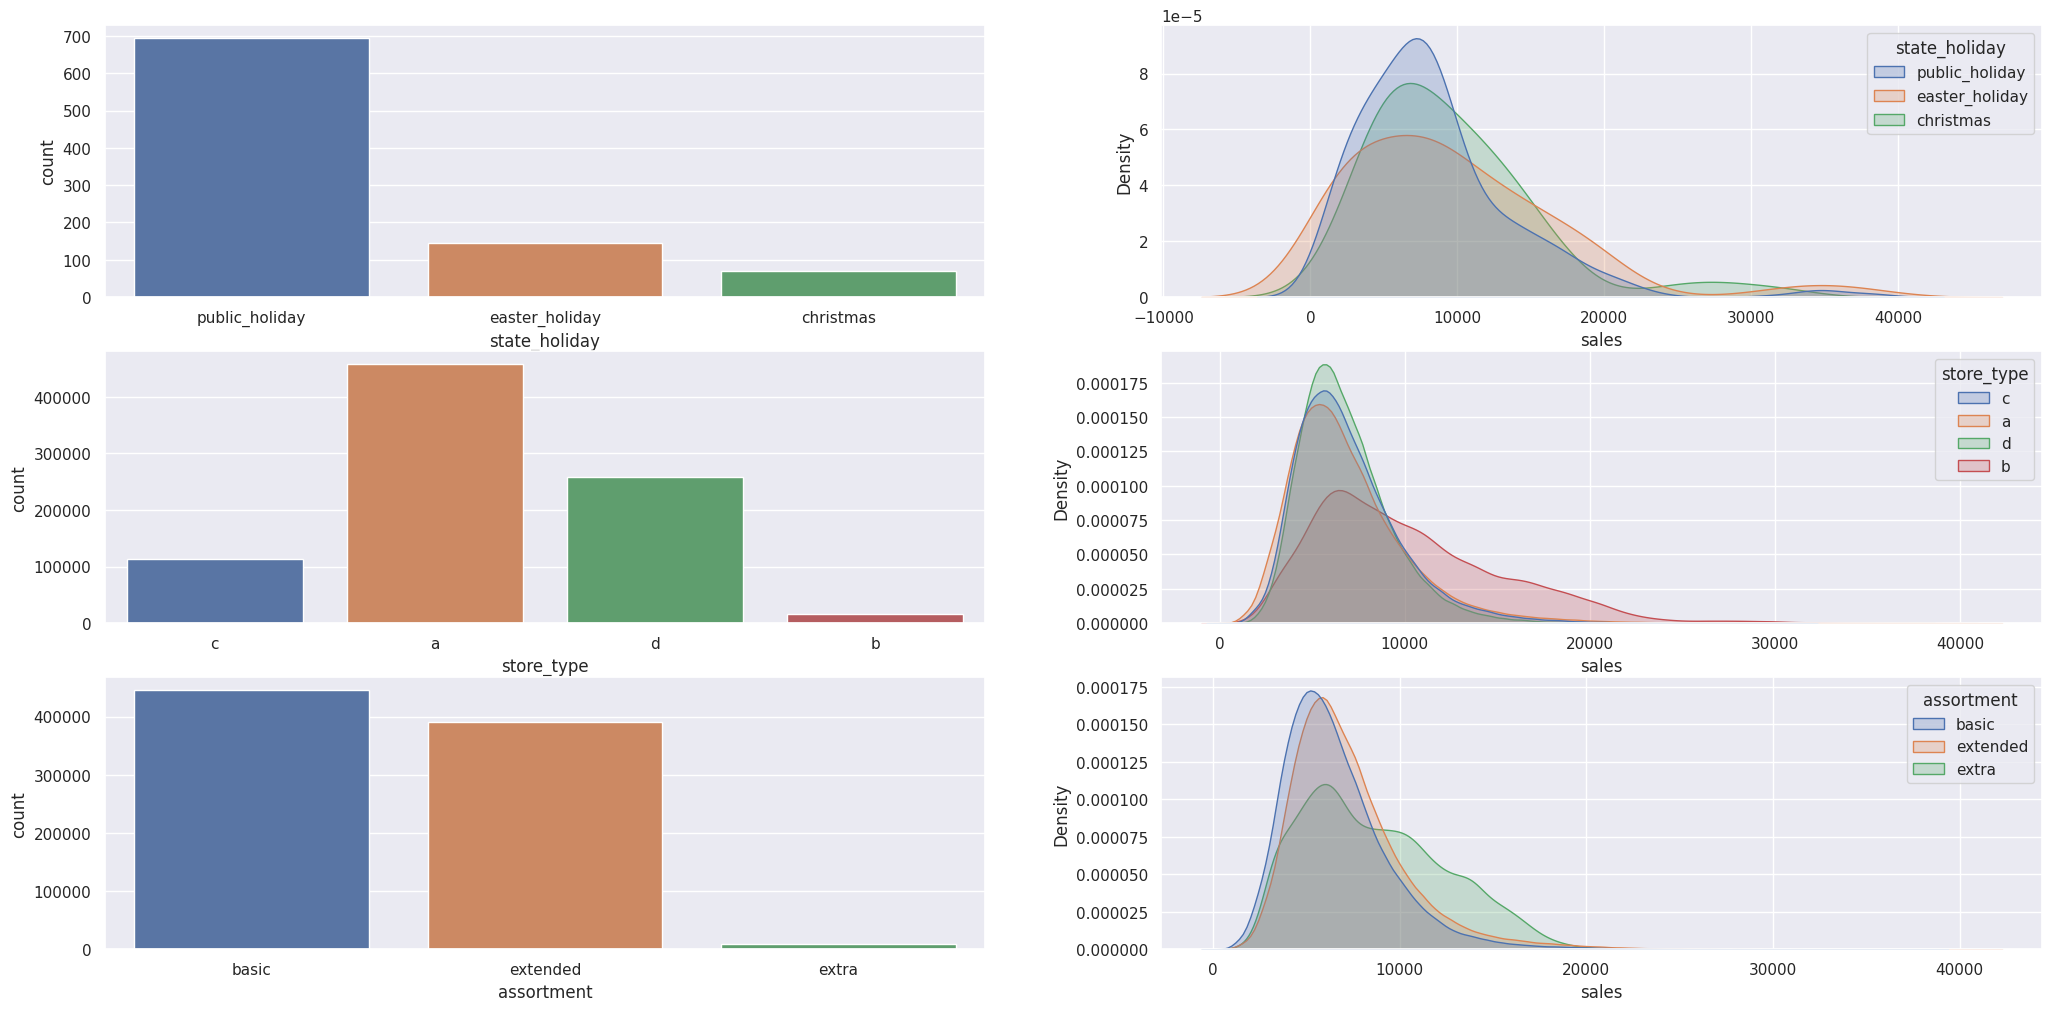

In [30]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x= a['state_holiday'])

plt.subplot( 3, 2, 2 )
sns.kdeplot(data=a, x='sales',hue='state_holiday', fill=True, common_norm=False)


# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x = df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot(data=df4, x='sales', hue='store_type', fill=True, common_norm=False)


# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x = df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot(data=df4, x='sales', hue='assortment', fill=True, common_norm=False);


#### Bivariada

##### **H1. Lojas com maior sortimentos deveriam vender mais.**
**Veradeiro** Lojas com MAIOR sortimento vendem mais em média.

- Lojas de sortimento extra equivale a menos de 1% dos nossos dados. 
- A média de venda dessas lojas supera a média de vendas.

- No entanto, no que vale ao retorno de vendas de todo o dataset, o sortimento Básico tem um maior somatório de vendas.
- Pode ser devido a sua grande quantidade de lojas de sortimento básico presente nos dados, equivale a 52%.

In [31]:
df4['assortment'].value_counts(normalize=True)*100

basic      52.68921
extended   46.33855
extra       0.97224
Name: assortment, dtype: float64

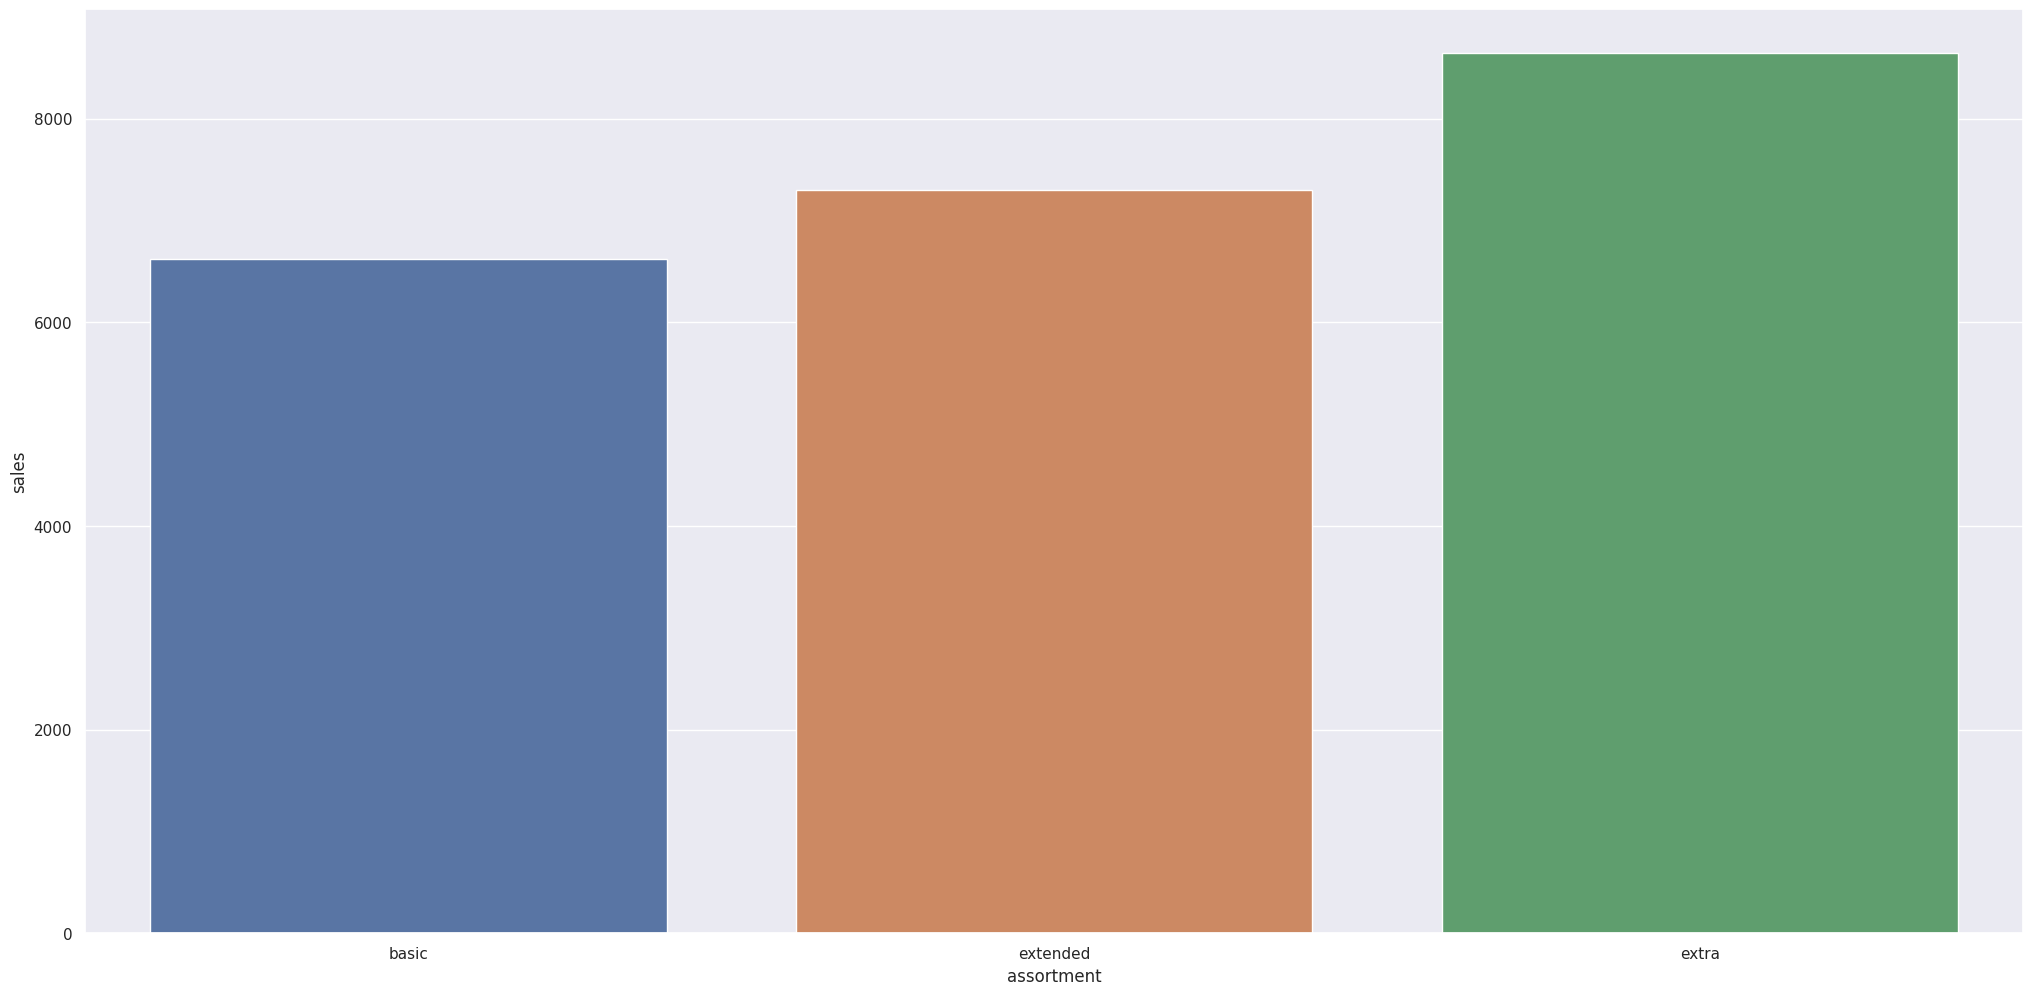

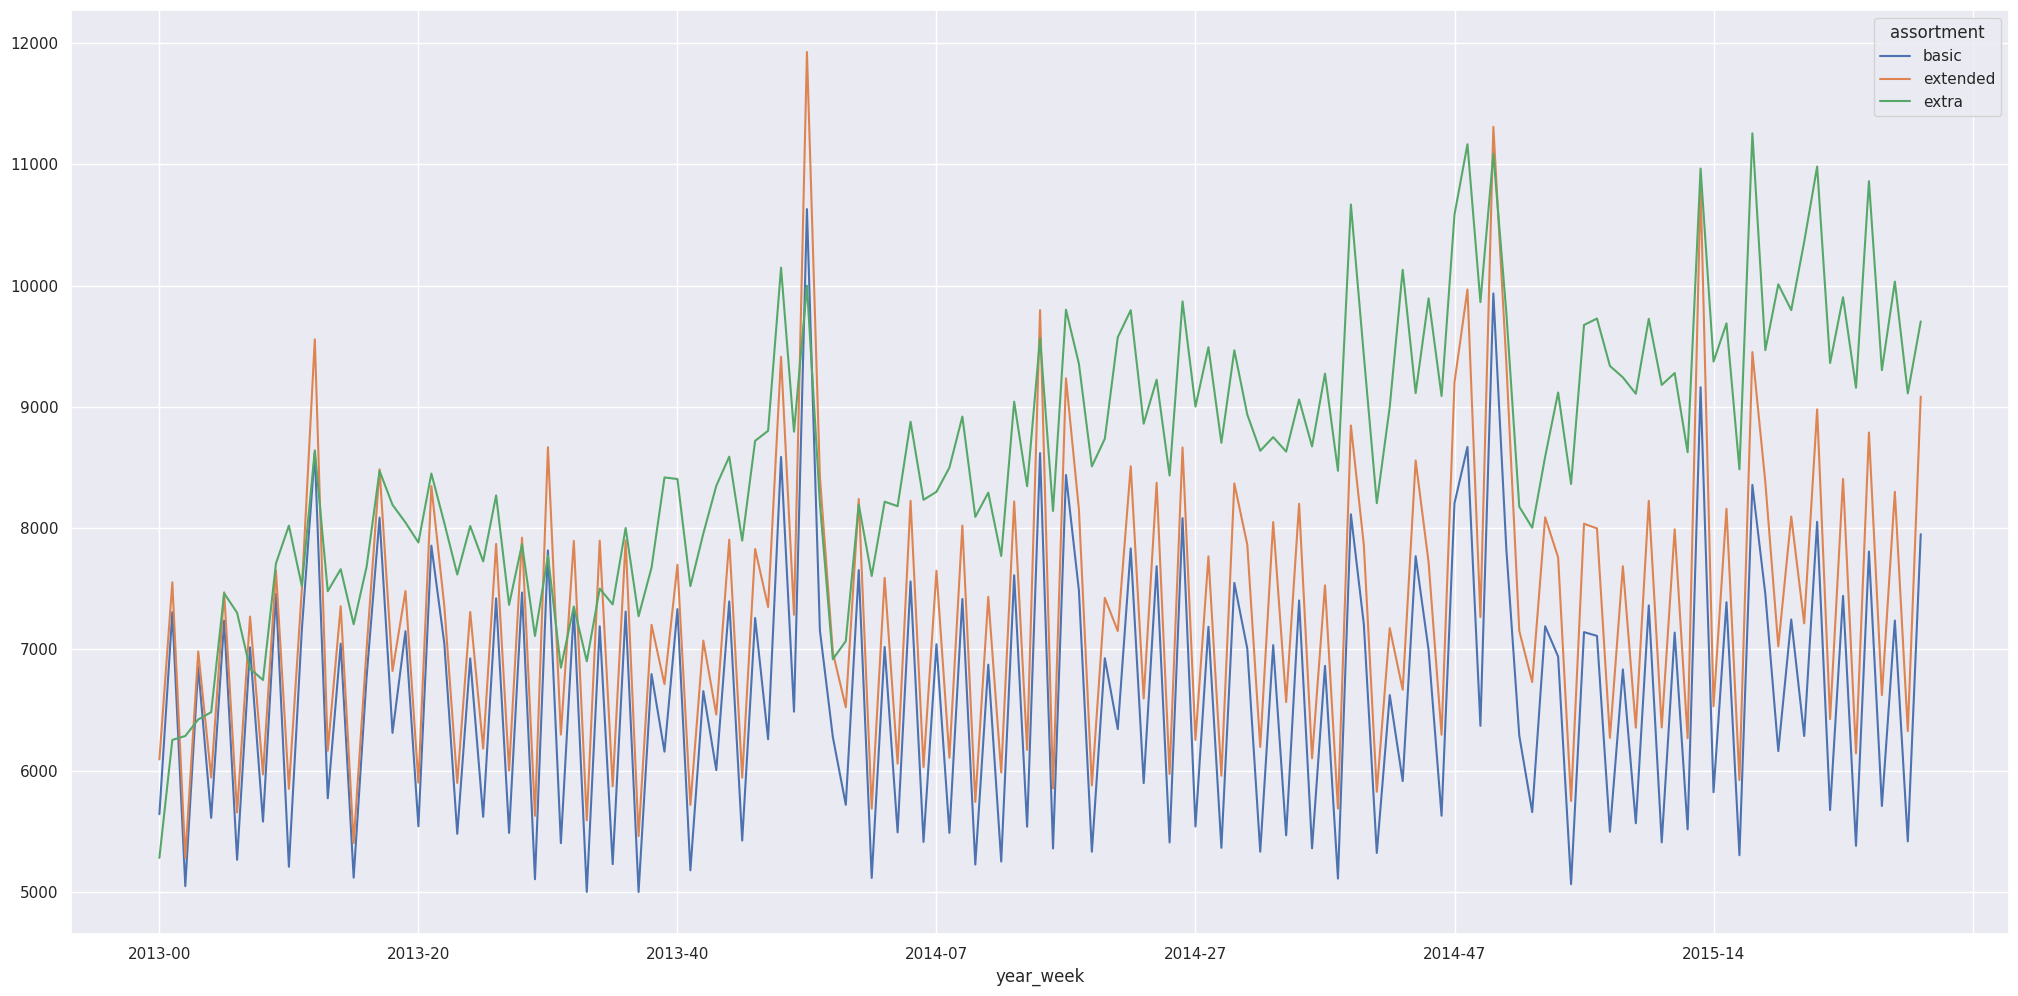

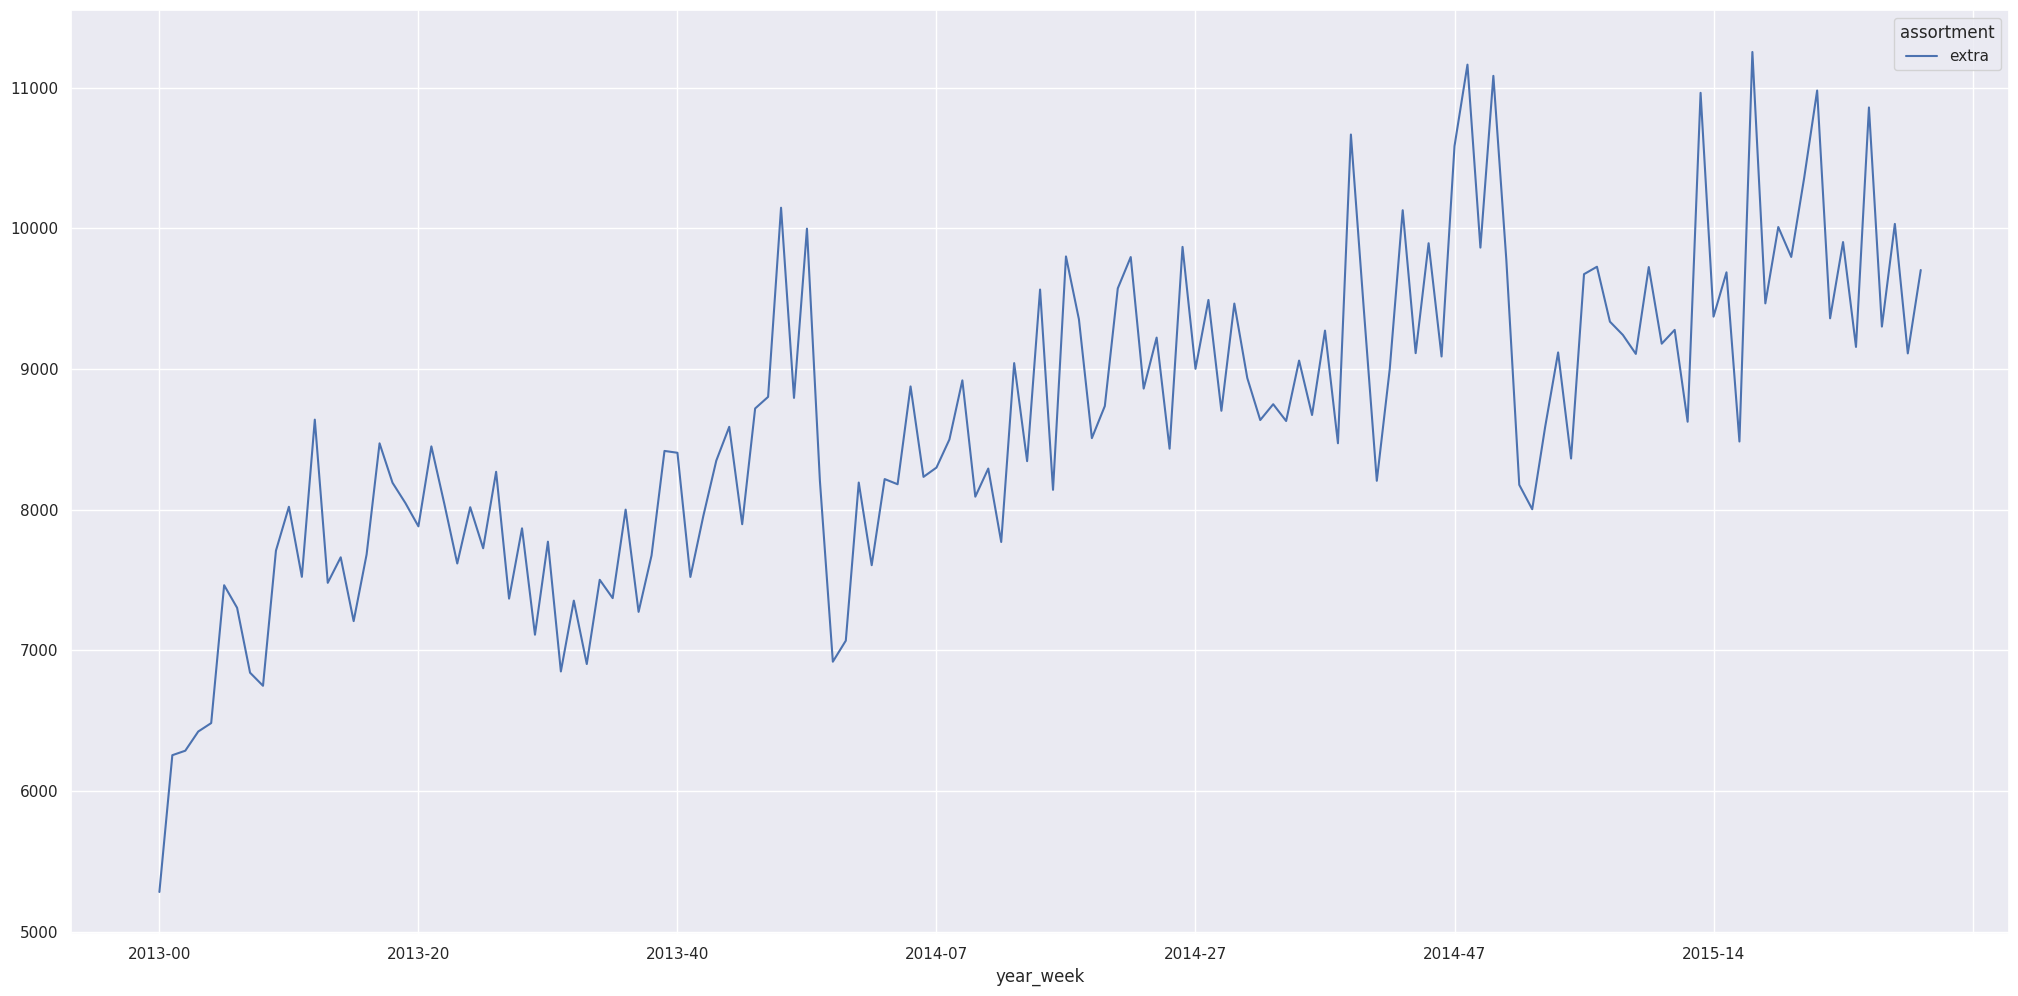

In [32]:
# media da venda de cada sortimento
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# preciso coonfirmar isso ao longo do tempo
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

# observando apenas as oscilações de venda ao longo do tempo do assortment extra
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

##### **H2. Lojas com competidores mais próximos deveriam vender menos.**
**FALSA** Não foi possivel confirmar uma correlação entre a distância de competidores com a quantidade de vendas da loja.

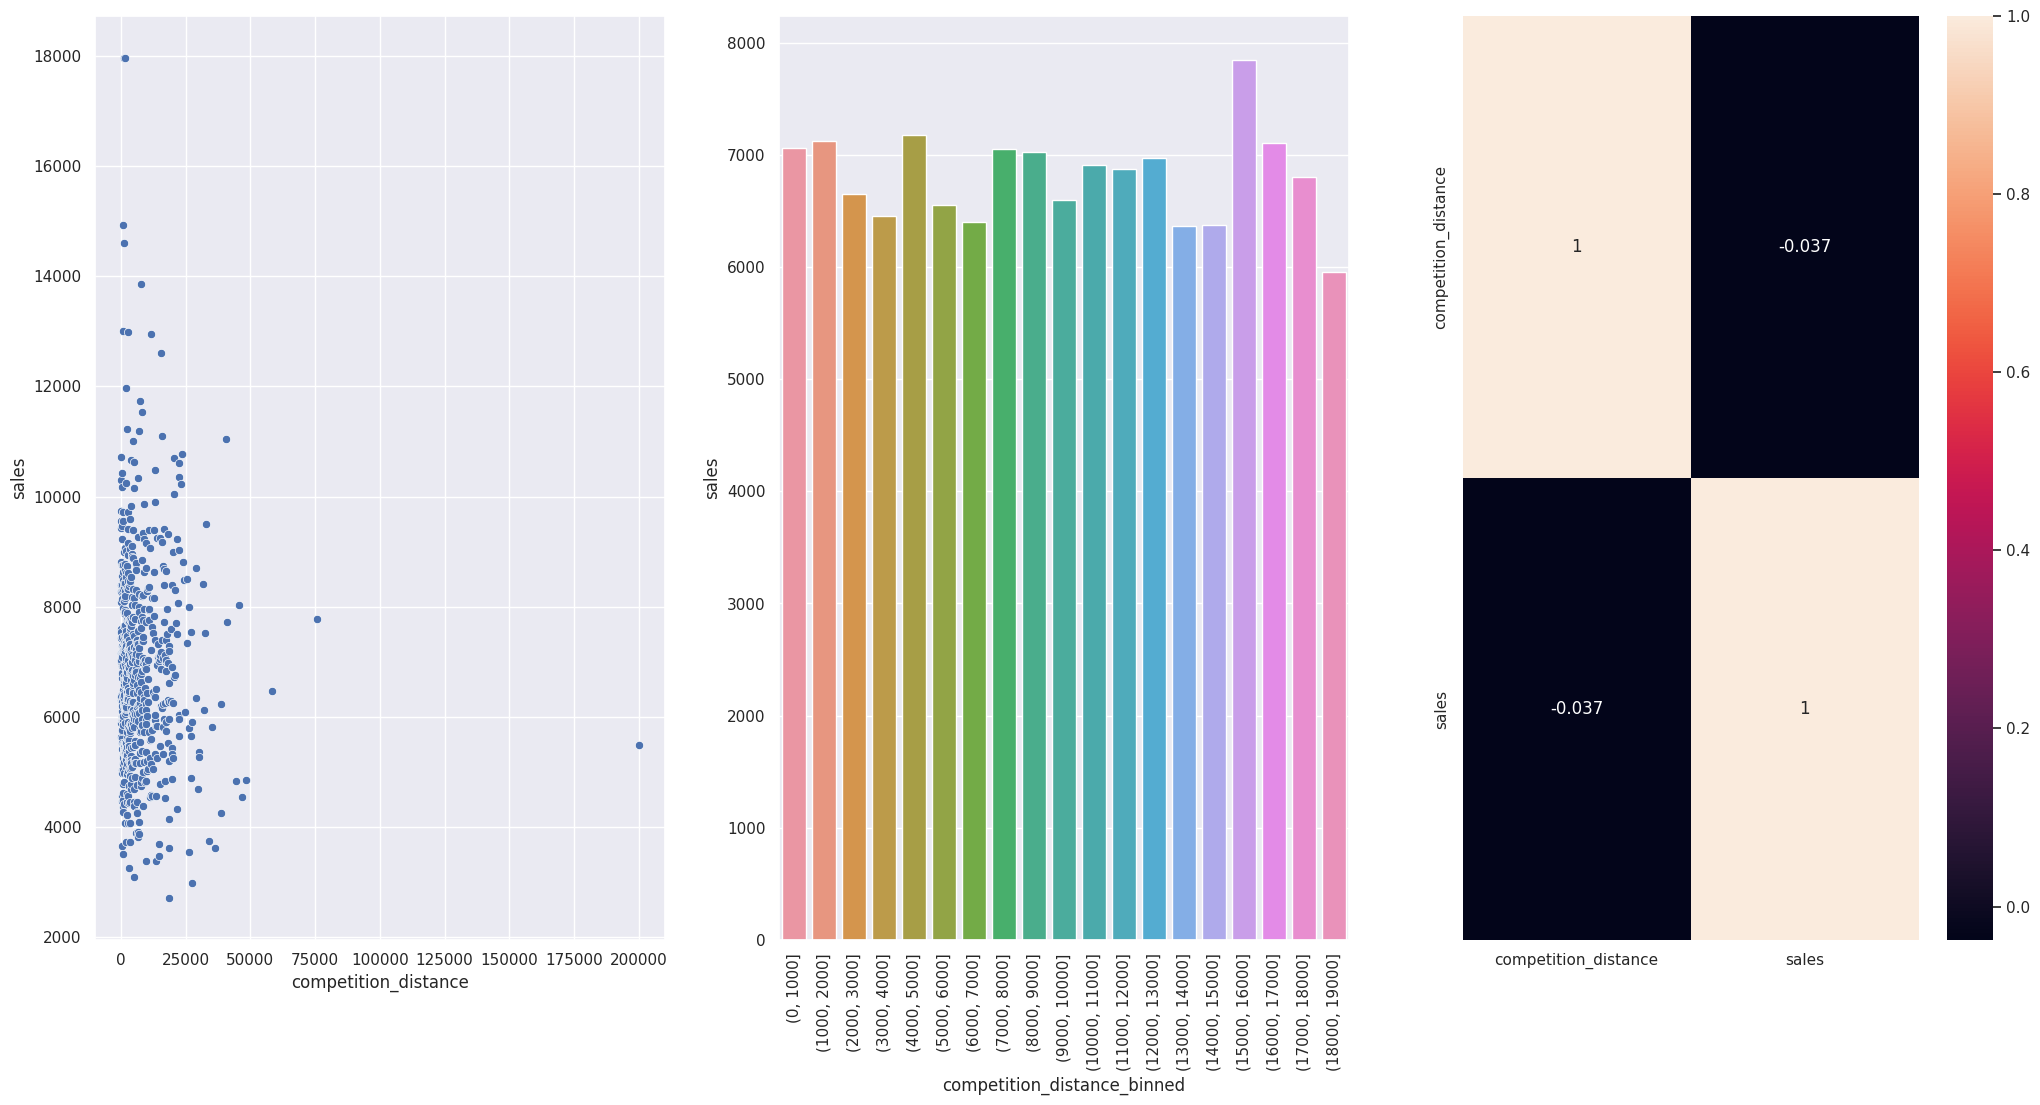

In [33]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
# bins seria a minha repartição em grupo da distancia de cada competidor
bins = list( np.arange(0,20000, 1000) )
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


##### **H3. Lojas com competidores à mais tempo deveriam vendem mais.**
**VERDADEIRO**

- As lojas que têm competidores a mais tempo, de fato vendem mais. 
- 

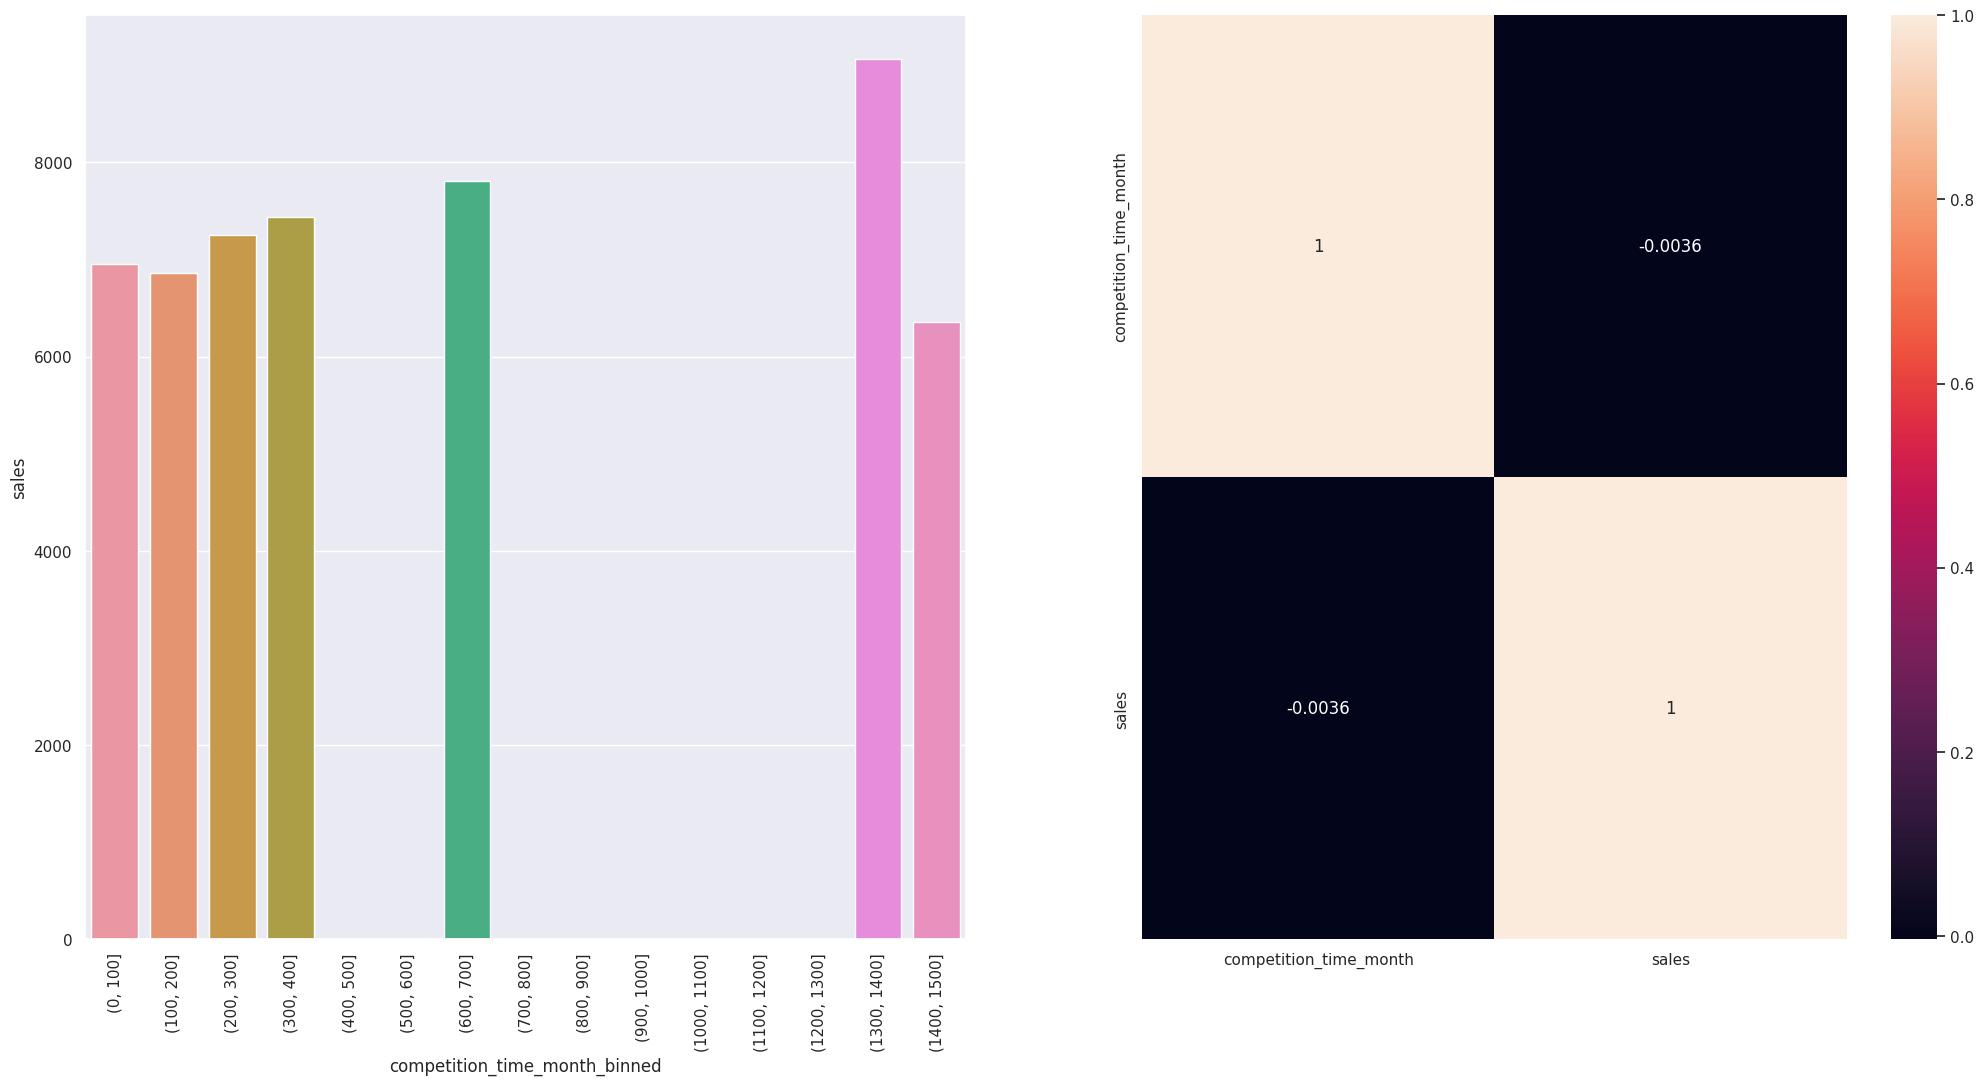

In [34]:
aux1 = df4[['competition_time_month', 'sales']]


plt.subplot(1,2,1)
# bins seria a minha repartição em grupo da distancia de cada competidor
bins = list( np.arange(0,1600, 100) )
aux1['competition_time_month_binned'] = pd.cut(aux1['competition_time_month'], bins=bins)
aux2 = aux1[['competition_time_month_binned', 'sales']].groupby('competition_time_month_binned').mean().reset_index()
sns.barplot(x='competition_time_month_binned', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### **H4. Lojas com promoções ativas por mais tempo deveriam vender mais.**
**VERDADEIRO** A média de vendas das lojas em escala de promoções tem um pequeno crescimento de vendas comparada as lojas que tem um curto tempo de promoção.

- 

In [35]:
## ASSUPTION: quando o valor no promo_time_week for negativo significa que a venda daquele dia ocorreu na promoção tradicional 
# e não na promoção extendida
# o feature promo_time_week foi montado com a date da venda - a ativação da promoção extendida

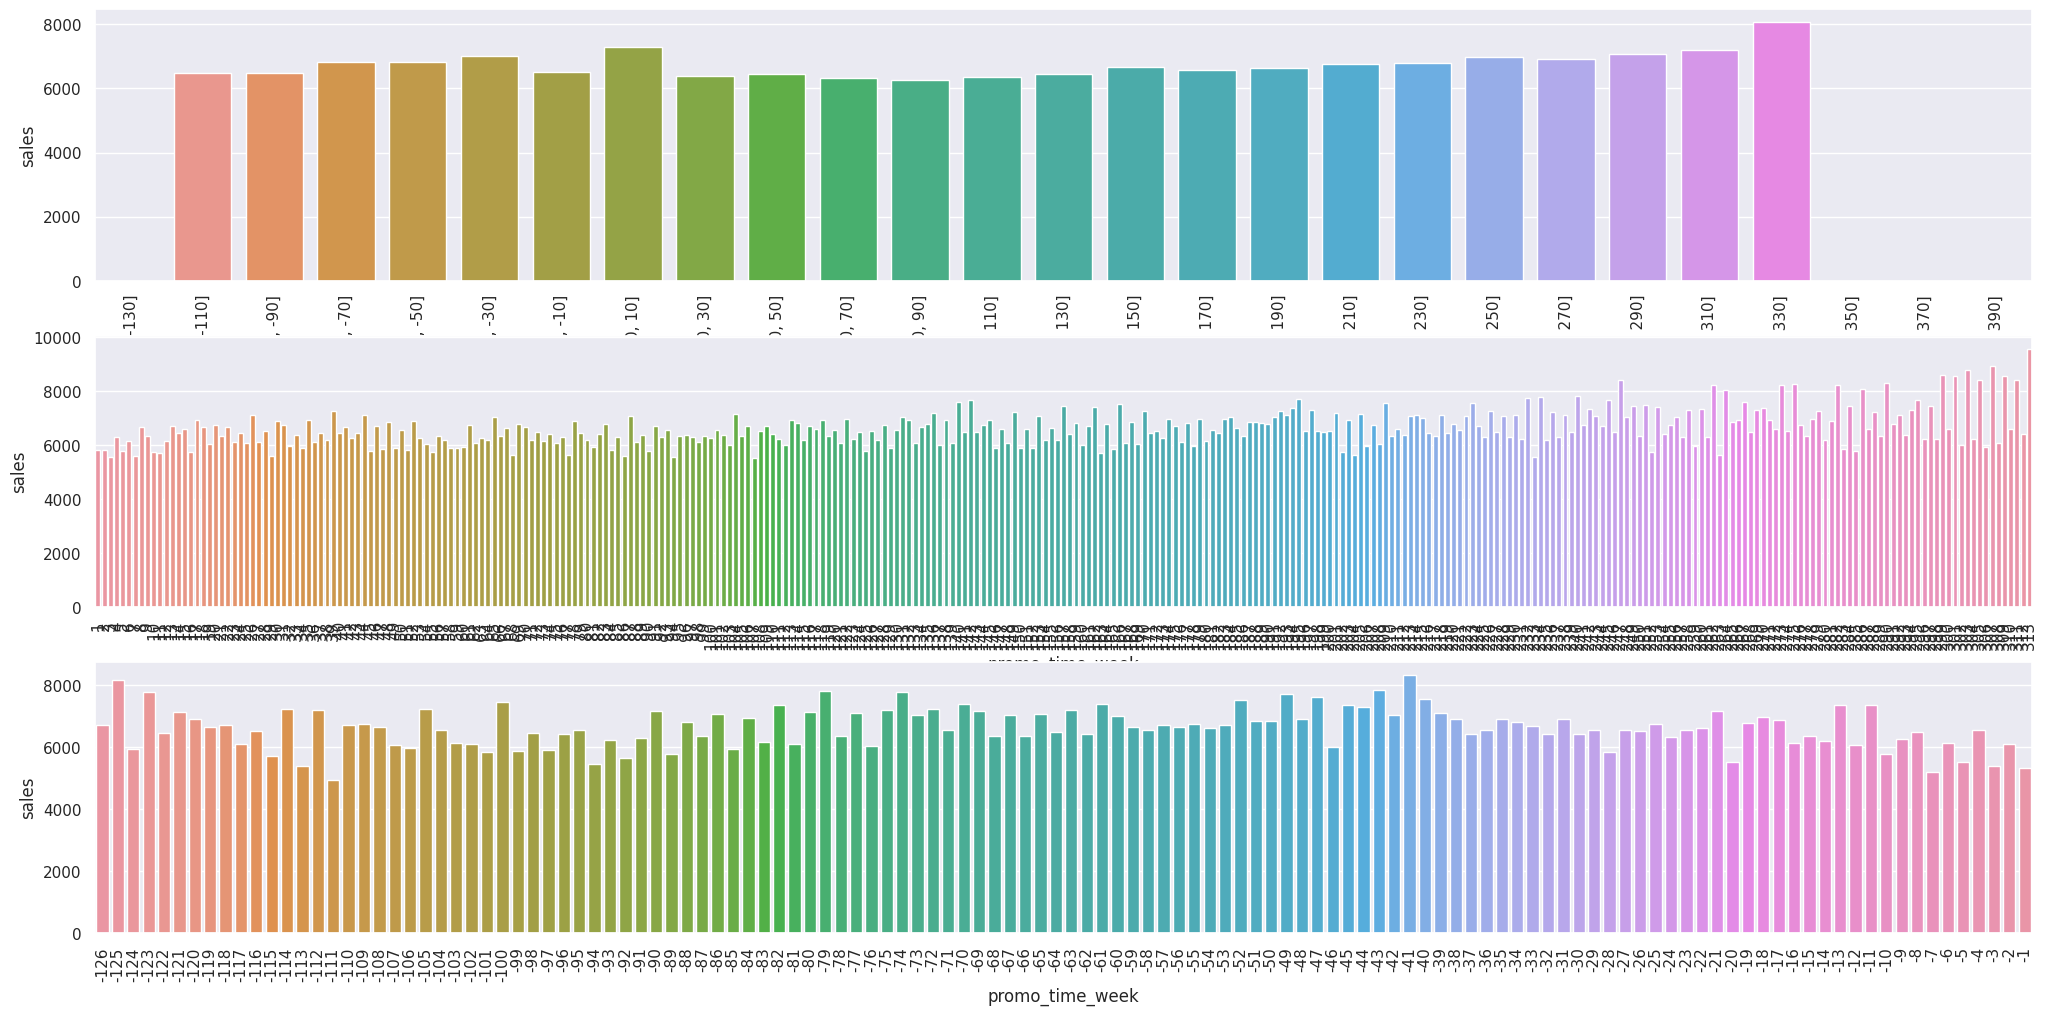

In [36]:
aux1 = df4[['promo_time_week', 'sales']]

plt.subplot(3,1,1)
# bins seria a minha repartição em grupo da distancia de cada competidor
bins = list( np.arange(-150,400, 20) )
aux1['promo_time_week_binned'] = pd.cut(aux1['promo_time_week'], bins=bins)
aux2 = aux1[['promo_time_week_binned', 'sales']].groupby('promo_time_week_binned').mean().reset_index()
sns.barplot(x='promo_time_week_binned', y='sales', data=aux2)
plt.xticks(rotation=90);


a1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

# plot do somatorio das vendas na promo extendida
plt.subplot(3,1,2)
a2 = a1[a1['promo_time_week'] > 0 ]
sns.barplot(x='promo_time_week', y= 'sales', data= a2)
plt.xticks(rotation=90);

# plot do somatorio das vendas na promo regular
plt.subplot(3,1,3)
a3 = a1[a1['promo_time_week'] < 0 ]
sns.barplot(x='promo_time_week', y= 'sales', data= a3)
plt.xticks(rotation=90);


##### **H5. Lojas com mais promoções consecutivas deveriam vender mais.**
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [37]:
# agrupando a média de vendas durante a promo e a promo2(consecutiva)
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index().sort_values(by='sales', ascending=False)

,promo,promo2,sales
2,1,0,8618.45206
3,1,1,7836.67299
0,0,0,6328.18763
1,0,1,5529.56668


Observação da tabela:
* a maior quantidade de vendas foi apenas quando há promo. 
* a promo2 (consecutiva) não é o maior valor de vendas

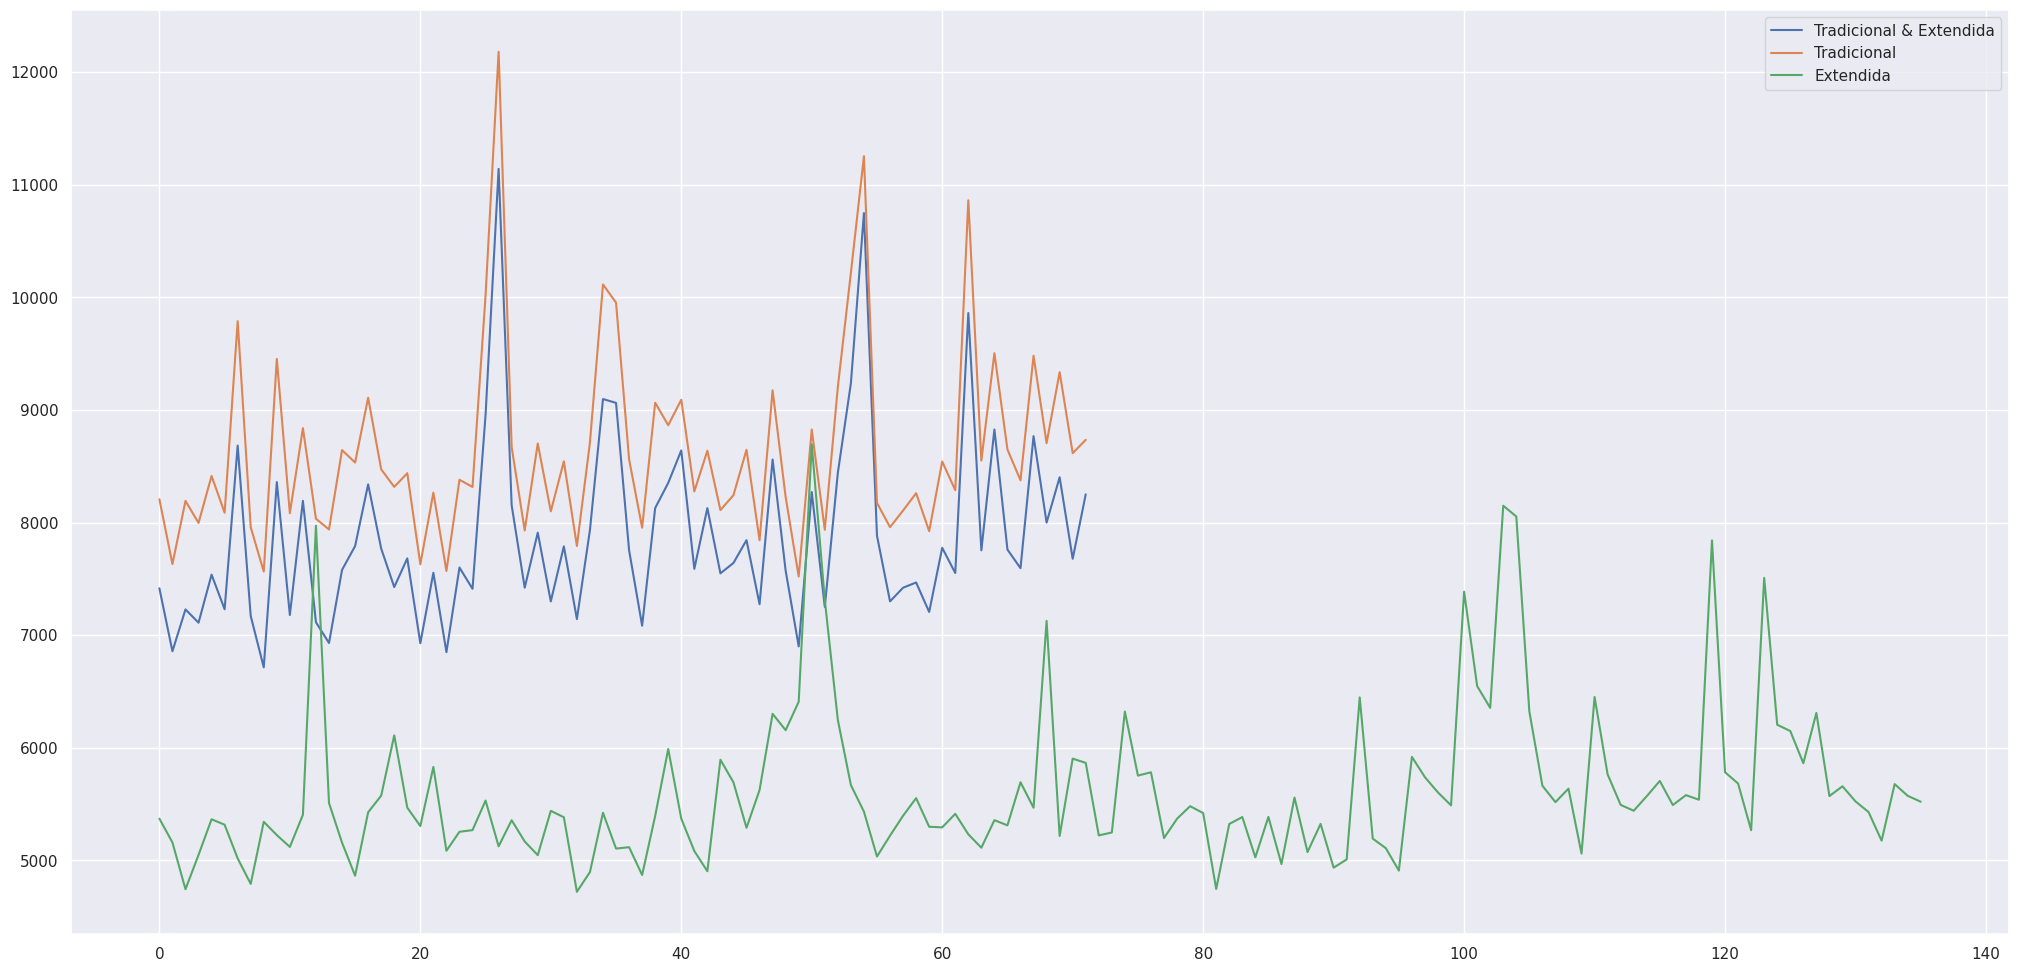

In [38]:
# observando ao longo do tempo
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax)

aux3 = df4[(df4['promo'] == 0) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux3.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Tradicional', 'Extendida']);

##### **H6. Lojas abertas durante o feriado de Natal deveriam vender mais.**
**VERDADEIRO** 
- Numa análise geral dos anos de 2013 e 2014, o feriado natalino tem uma média de vendas maior que os outros feriados do ano.
- Já numa análise detalhada de cada ano, foi possivel observar que no ano de 2013, o feriado da pásco superou a media de vendas do Natal.

- Comparativo entre os outros feriados
- Como o ano de 2015 não foi finalizado, foi excluido da análise
- Como existem quantidade diferente de registro de cada feriado foi calculado a média e não o somatório de vendas de cada feriado.

In [39]:
df4['state_holiday'].value_counts()

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

In [79]:
aux = df4[(df4['state_holiday'] != 'regular_day') & (df4['year'] != 2015)]

aux1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()

aux1

,state_holiday,sales
0,christmas,9743.74648
1,easter_holiday,9566.14583
2,public_holiday,8257.53293


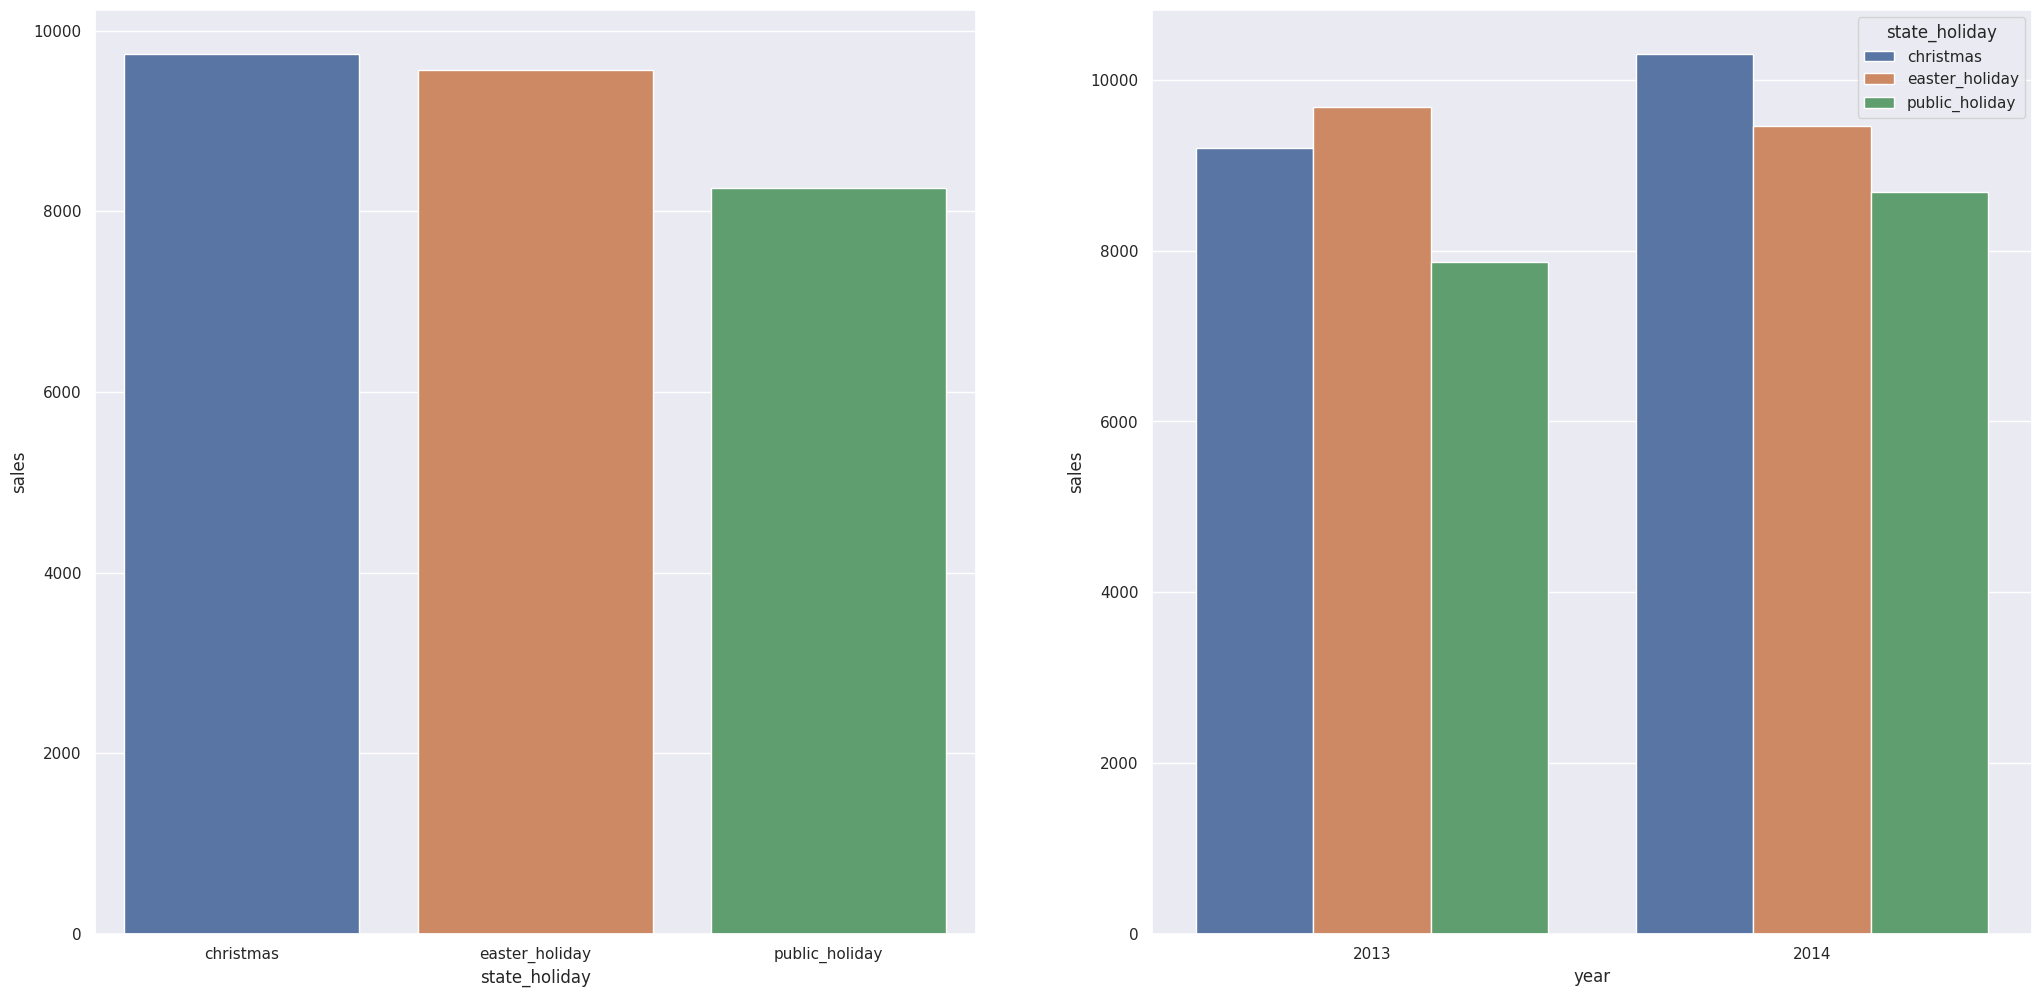

In [78]:
aux = df4[(df4['state_holiday'] != 'regular_day') & (df4['year'] != 2015)]
plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()

sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

##### **H7. Lojas deveriam vender mais ao longo dos anos.**
**FALSA** 
- Ao longo dos anos, foi possivel observar um declinio de vendas das lojas.

- Como o ano de 2015 não foi finalizado, por isso há uma queda drástica no somatório de vendas.

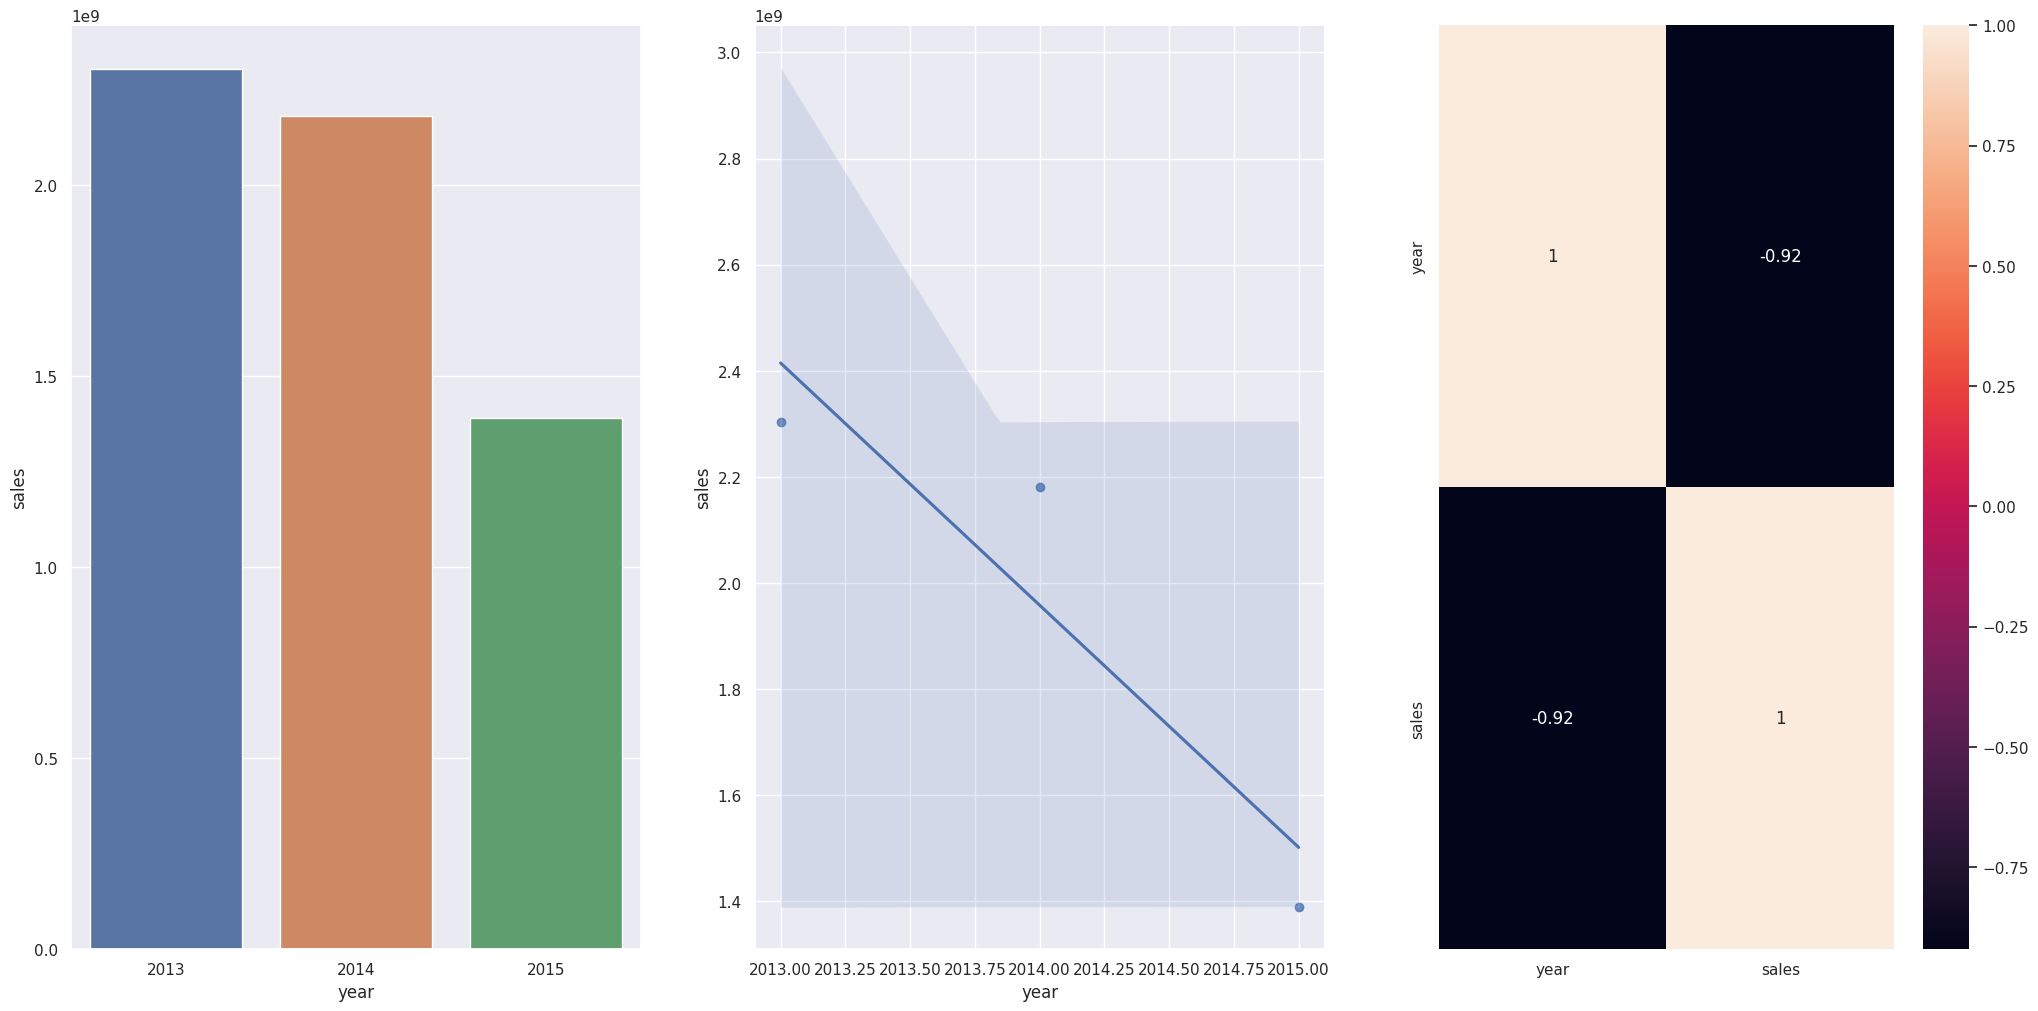

In [41]:
plt.subplot(1,3,1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### **H8. Lojas deveriam vender mais no segundo semestre do ano.**
**FALSA** Vendem menos no segundo semestre.

In [42]:
aux1

,year,sales
0,2013,2302876084
1,2014,2180804896
2,2015,1389499643


In [43]:
# plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').mean().reset_index()
# sns.barplot(x='month', y='sales', data=aux1)

# plt.subplot(1,3,2)
# sns.regplot(x='month',y='sales',data=aux1)

# plt.subplot(1,3,3)
# sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H9. Lojas deveriam vender mais depois do dia 10 de cada mês.**
**VERDADEIRO**

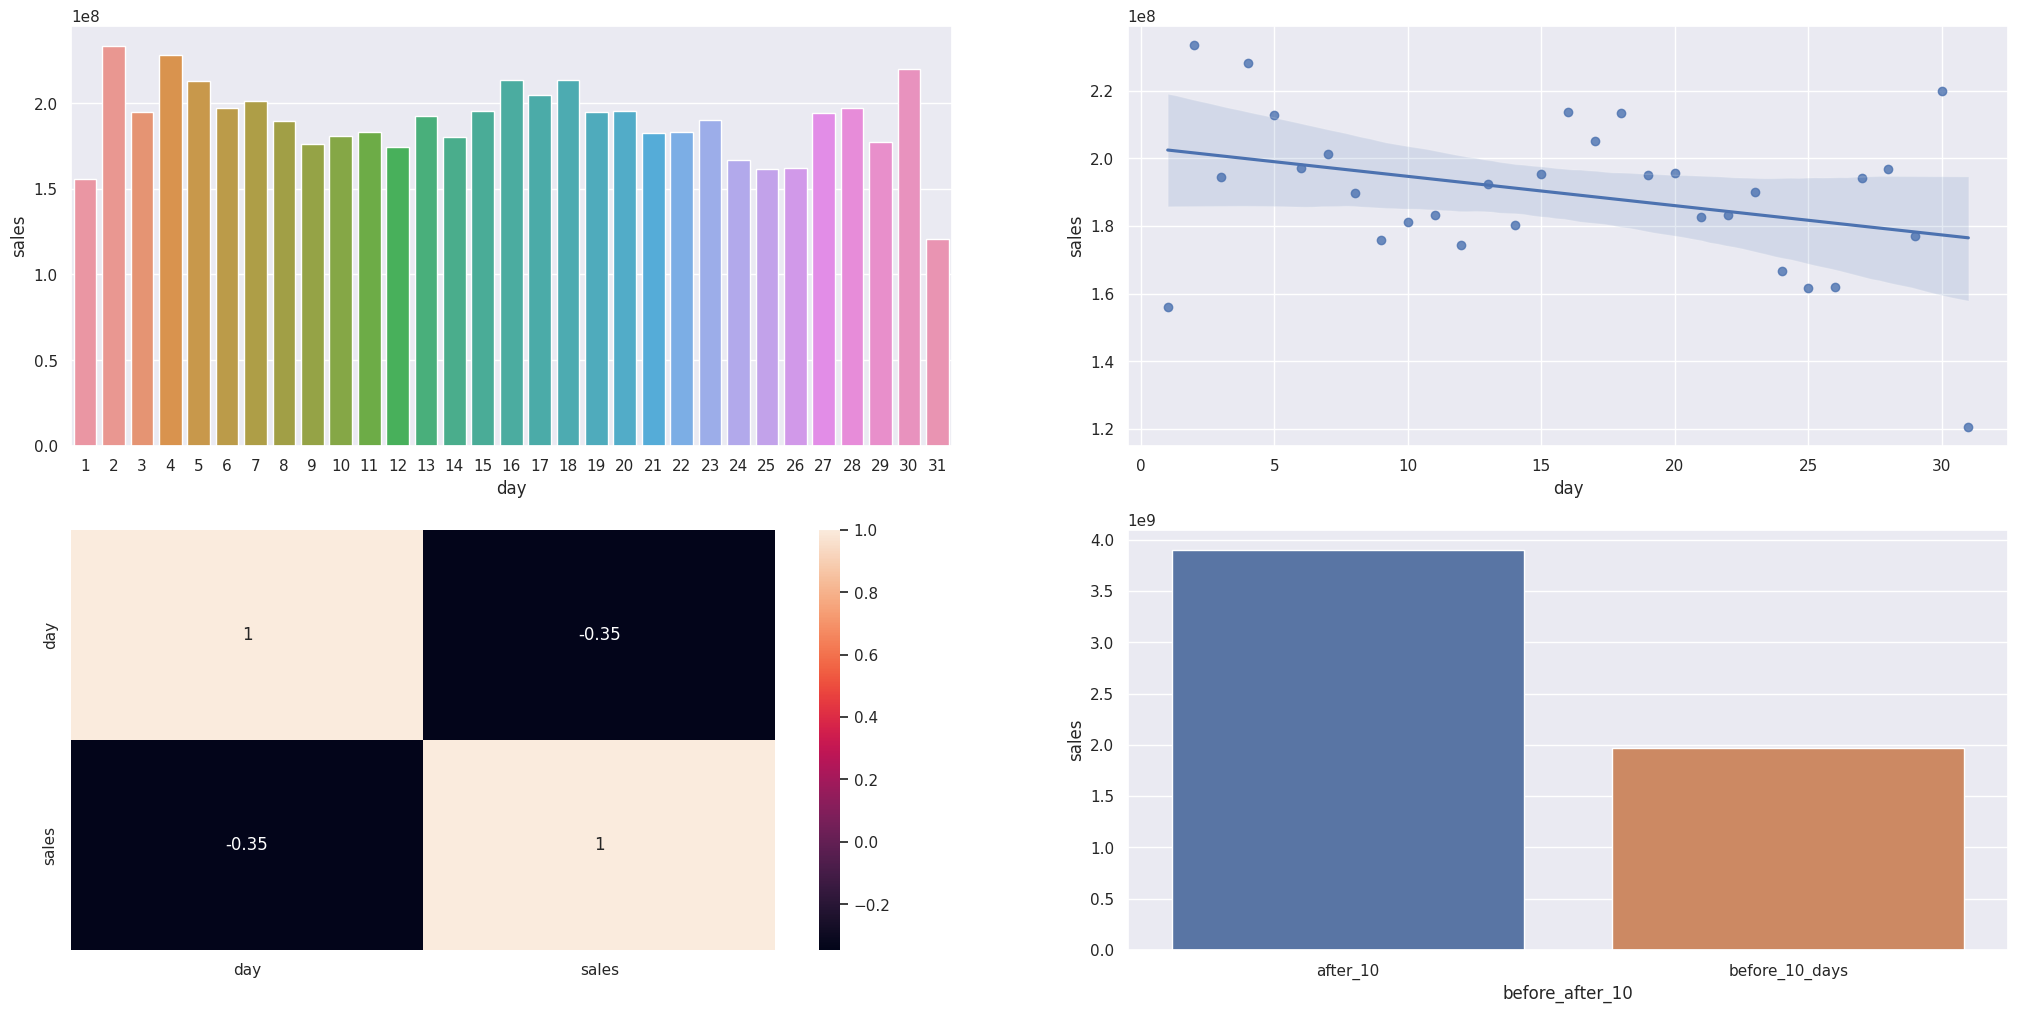

In [44]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after_10'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10')
aux2 = aux1[['before_after_10','sales']].groupby('before_after_10').sum().reset_index()
sns.barplot(x='before_after_10', y='sales', data=aux2);

##### **H10. Lojas deveriam vender menos aos finais de semana.**
**VERDADEIRO**

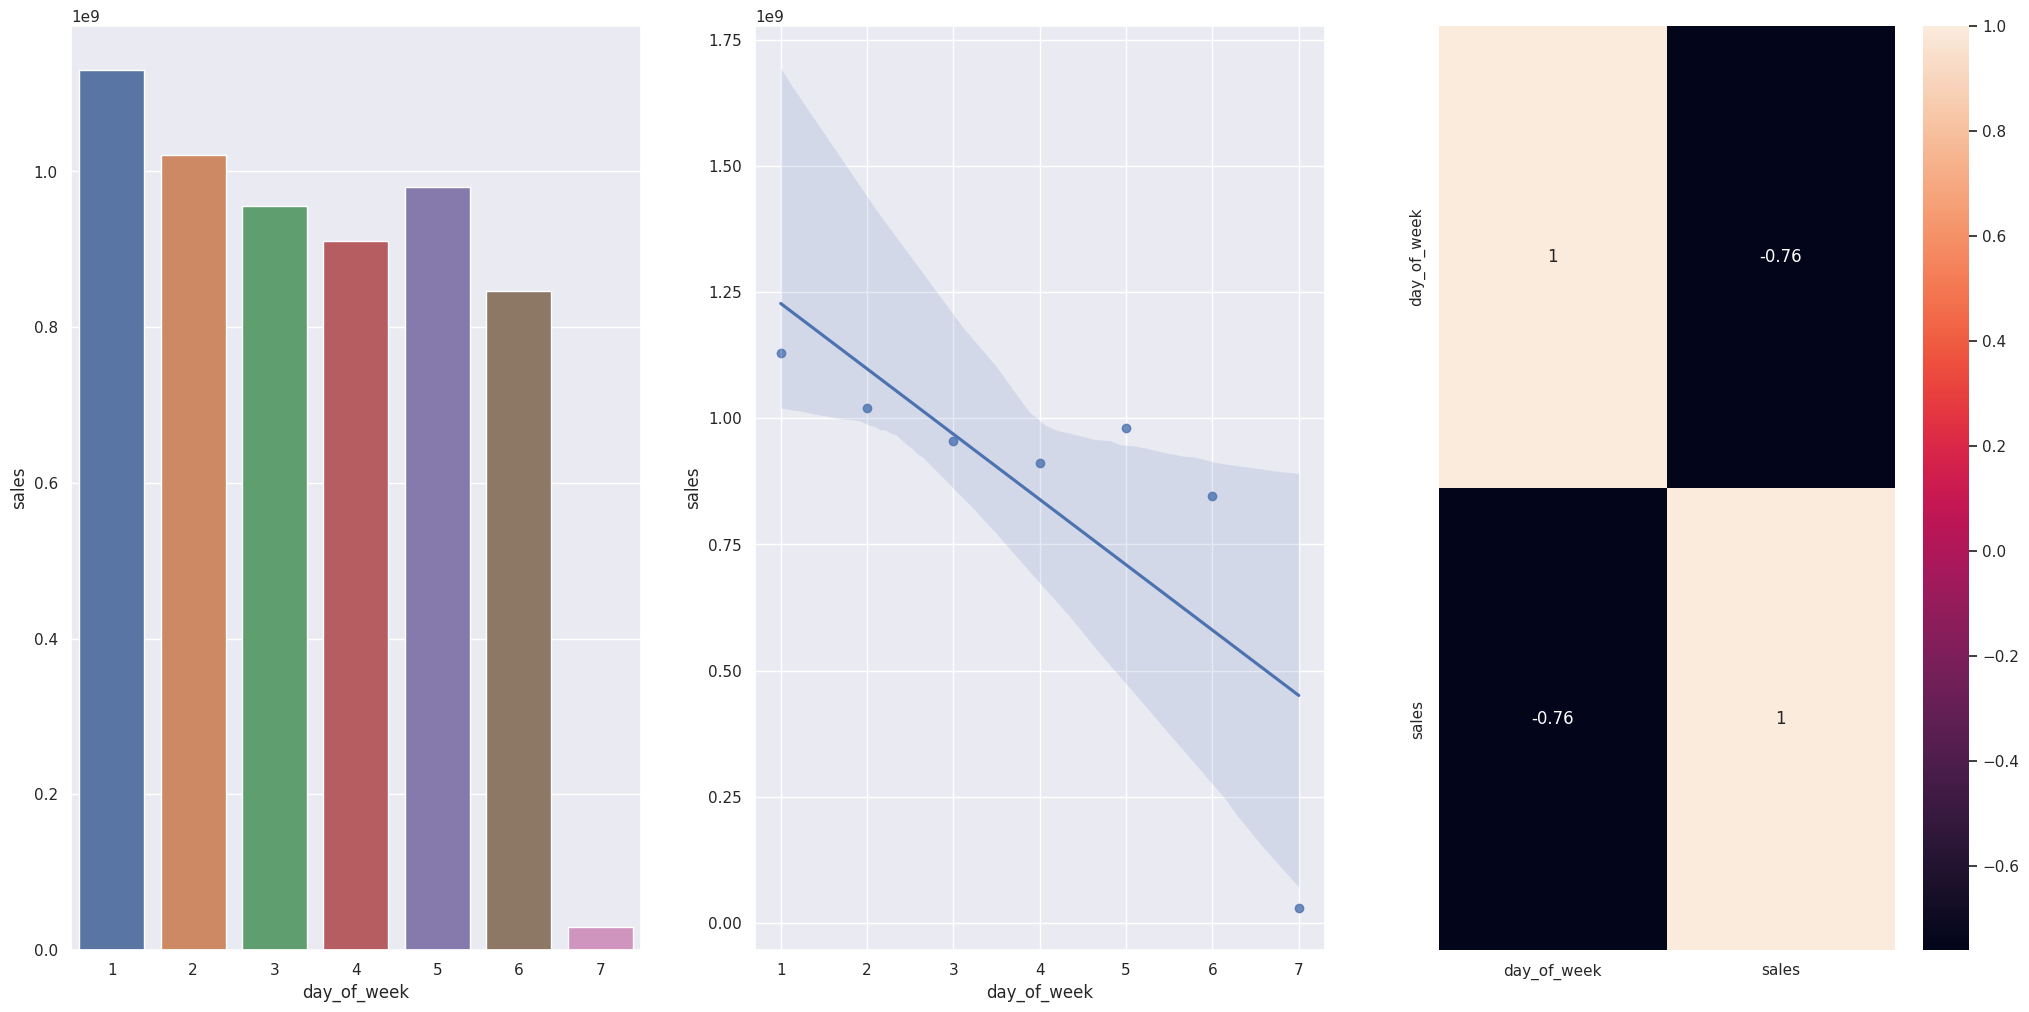

In [45]:
plt.subplot(1,3,1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### **H11. Lojas deveriam vender menos durante os feriados escolares.**
**VERDADEIRO** Exceto nos meses Julho e agosto, periodo de ferias. 

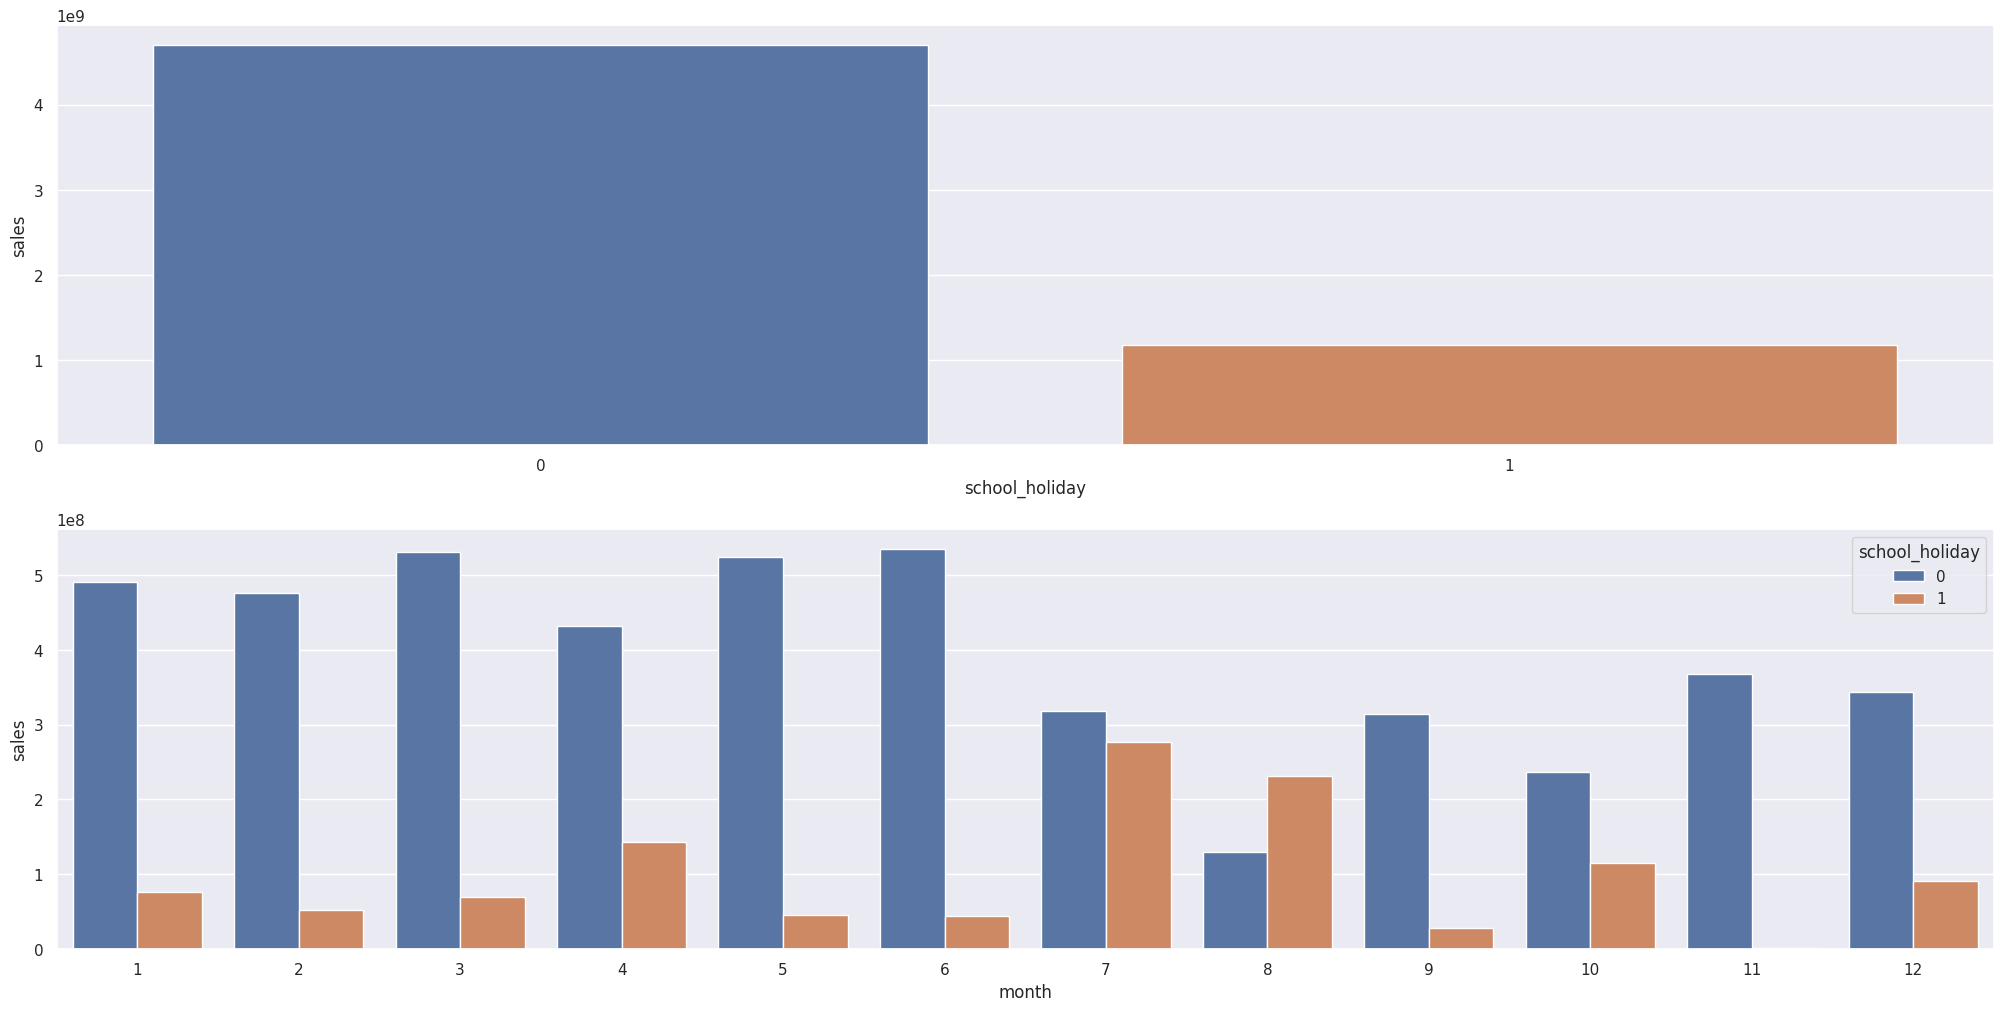

In [46]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## Insights de Negócio

In [218]:
df_in = df2.copy()

In [219]:
# as restrições observadas para o negócio foram loja fechada e vendas nulas
df_in = df_in[(df_in['open'] != 0) & (df_in['sales'] != 0 )]

# a coluna customers é uma restrição para o modelo, pois tem essa informação daqui 6 semanas
# a não ser que eu faça outro modelo de previsão para calcular a coluna customers daqui 6 semanas.
# então por isso, foi retirar essa coluna do meu dataset para fazer a predição de vendas daqui 6 semanas.
cols_drop = ['open', 'promo_interval', 'month_map']
df_in = df_in.drop(cols_drop, axis=1)

In [15]:
def millify(n):
    n = float(n)
    
    millnames = ['',' K',' M',' B',' T']
    
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return {str(n / 10**(3 * millidx)) + str(millnames[millidx])}

# df['Value in millions'] = df['Market value'].apply(lambda n: millify(n))

In [16]:
millify(5873180623)

ValueError: Unknown format code 'f' for object of type 'str'

In [4]:
import math

**Total das vendas**

In [82]:
df_in['sales'].sum()

5873180623

In [83]:
anos = list(df_in['year'].unique())
anos

[2015, 2014, 2013]

In [84]:
for i in anos:
    x = df_in.loc[df_in['year'] == i, 'sales'].sum()
    print(x, i)

1389499643 2015
2180804896 2014
2302876084 2013


**Total de clientes**

In [85]:
df_in['customers'].sum()

644041747

In [86]:
anos = list(df_in['year'].unique())

In [87]:
for i in anos:
    x = df_in.loc[df_in['year'] == i, 'customers'].sum()
    print(x, i)

147548359 2015
240488968 2014
256004420 2013


**Número de lojas**

In [88]:
df_in['store'].sum()

471496386

**total de vendas ao longo do tempo**

In [89]:
# df_in['week_of_year'] = df_in['week_of_year'].astype(str)

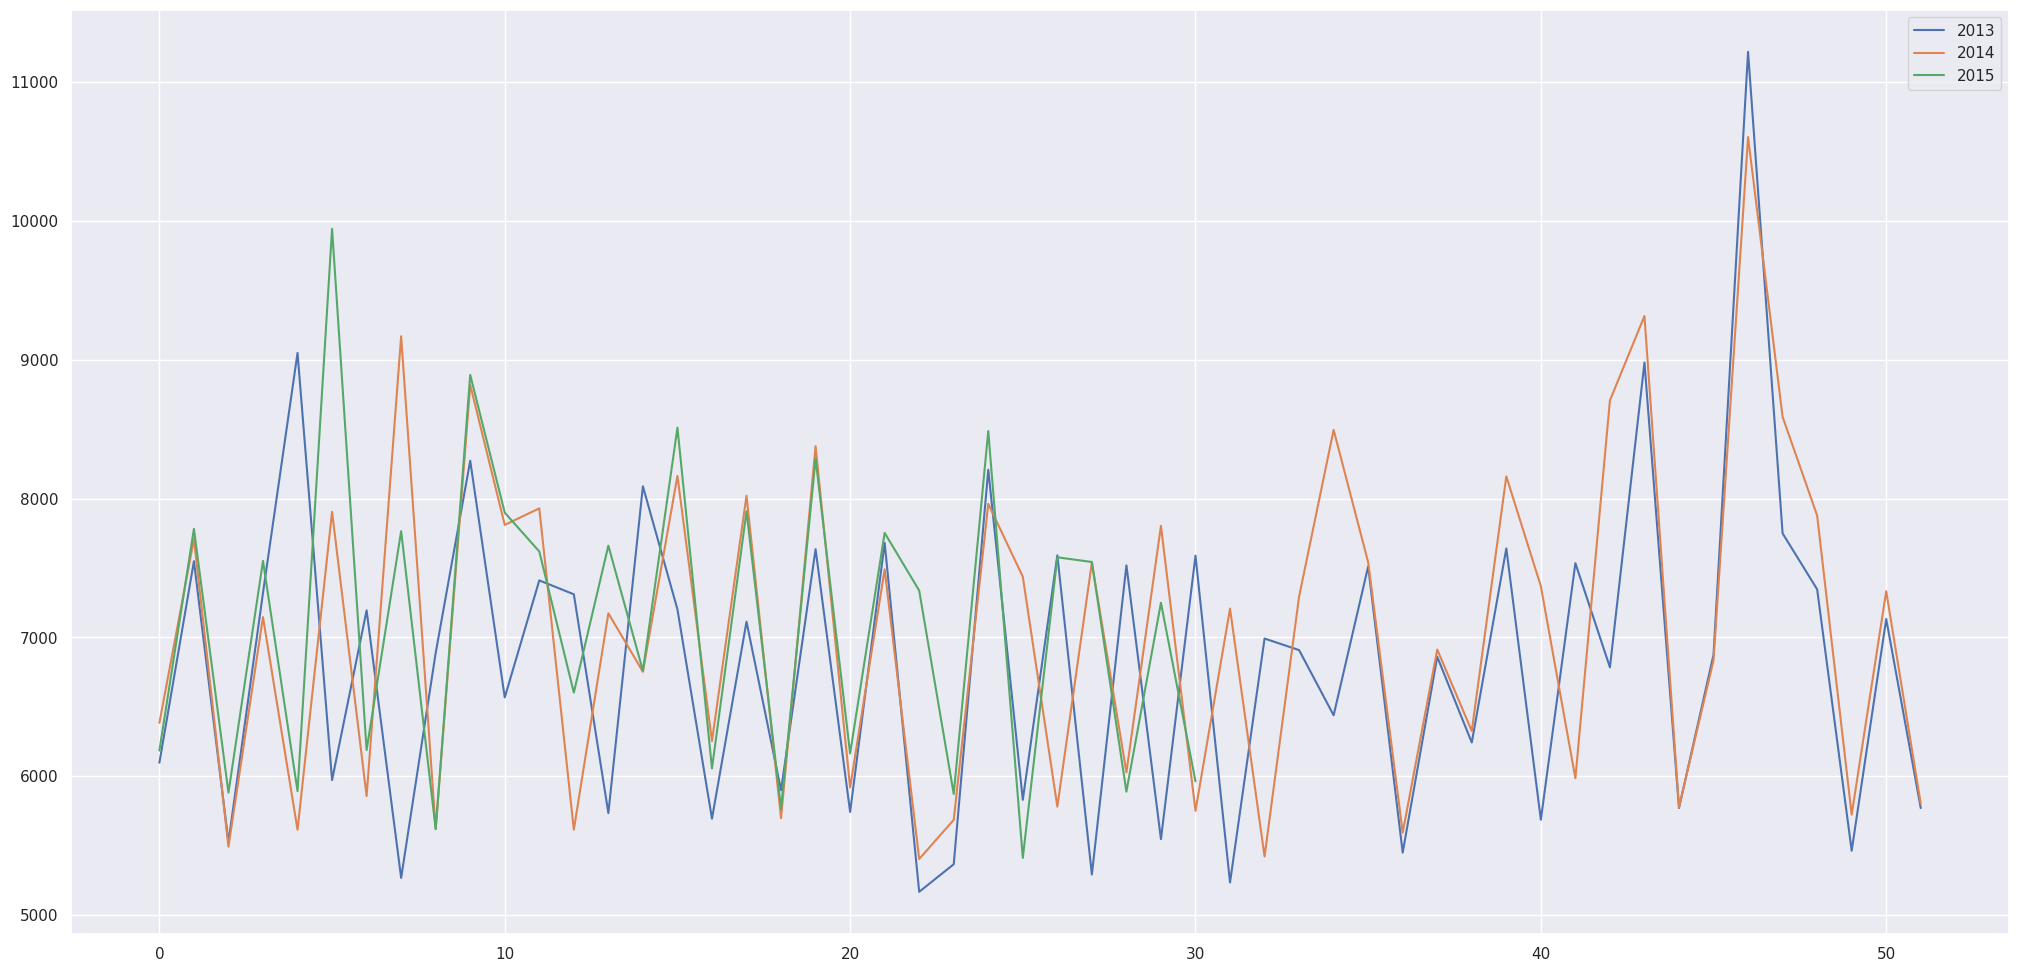

In [90]:
# aux_13 = df_in[df_in['year'] == 2013][['week_of_year','sales']].groupby('week_of_year').mean().reset_index()
# ax = aux_13.plot()

# aux_14 = df_in[df_in['year'] == 2014][['week_of_year','sales']].groupby('week_of_year').mean().reset_index()
# aux_14.plot(ax=ax)

# aux_15 = df_in[df_in['year'] == 2015][['week_of_year','sales']].groupby('week_of_year').mean().reset_index()
# aux_15.plot(ax=ax)

# ax.legend(labels=['2013', '2014', '2015']);

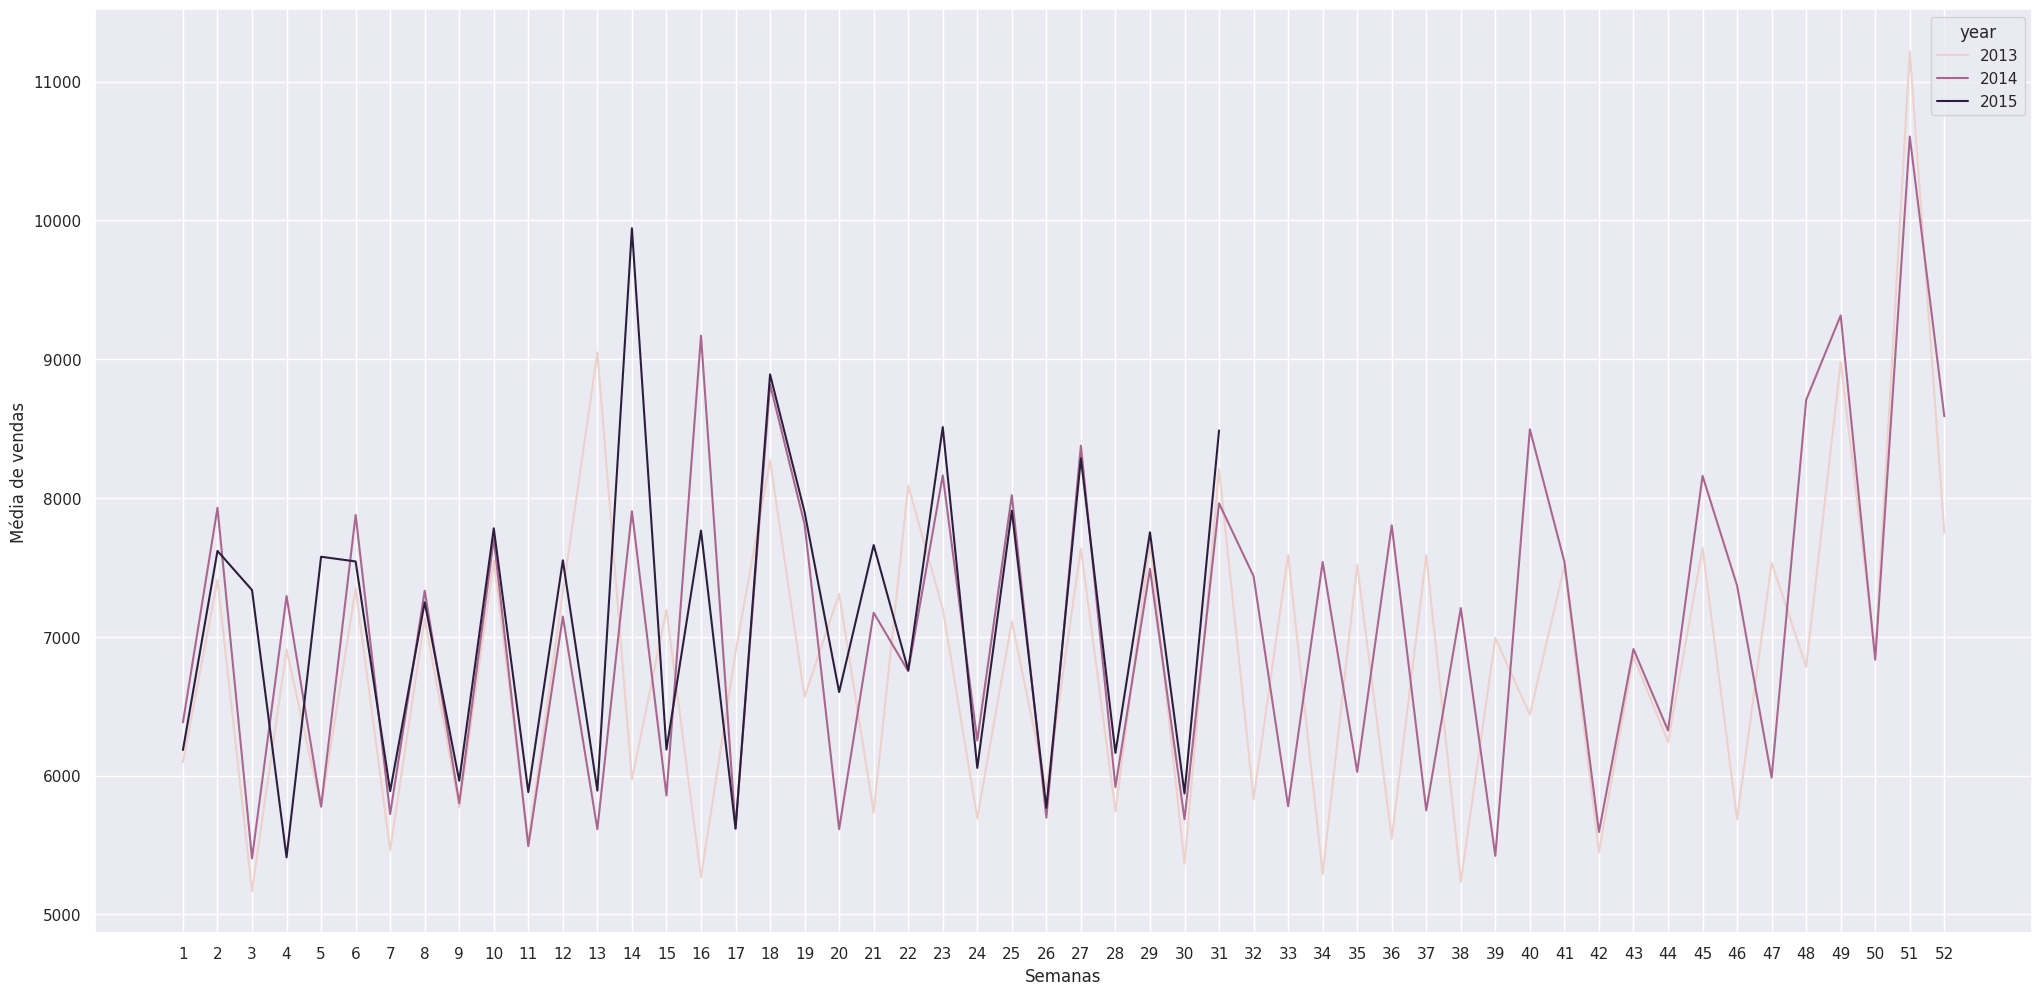

In [221]:
sns.set_theme(style="darkgrid")

aux_plot = df_in[['week_of_year','year' ,'sales']].groupby(['week_of_year', 'year']).mean().reset_index().sort_values(by= ['year','week_of_year'])
aux_plot['week_of_year'] = aux_plot['week_of_year'].astype(str)

ax = sns.lineplot(x="week_of_year", y="sales",
             hue="year",
             data=aux_plot);
ax.set( xlabel = 'Semanas' ,ylabel='Média de vendas');

**Soma das vendas por ano**

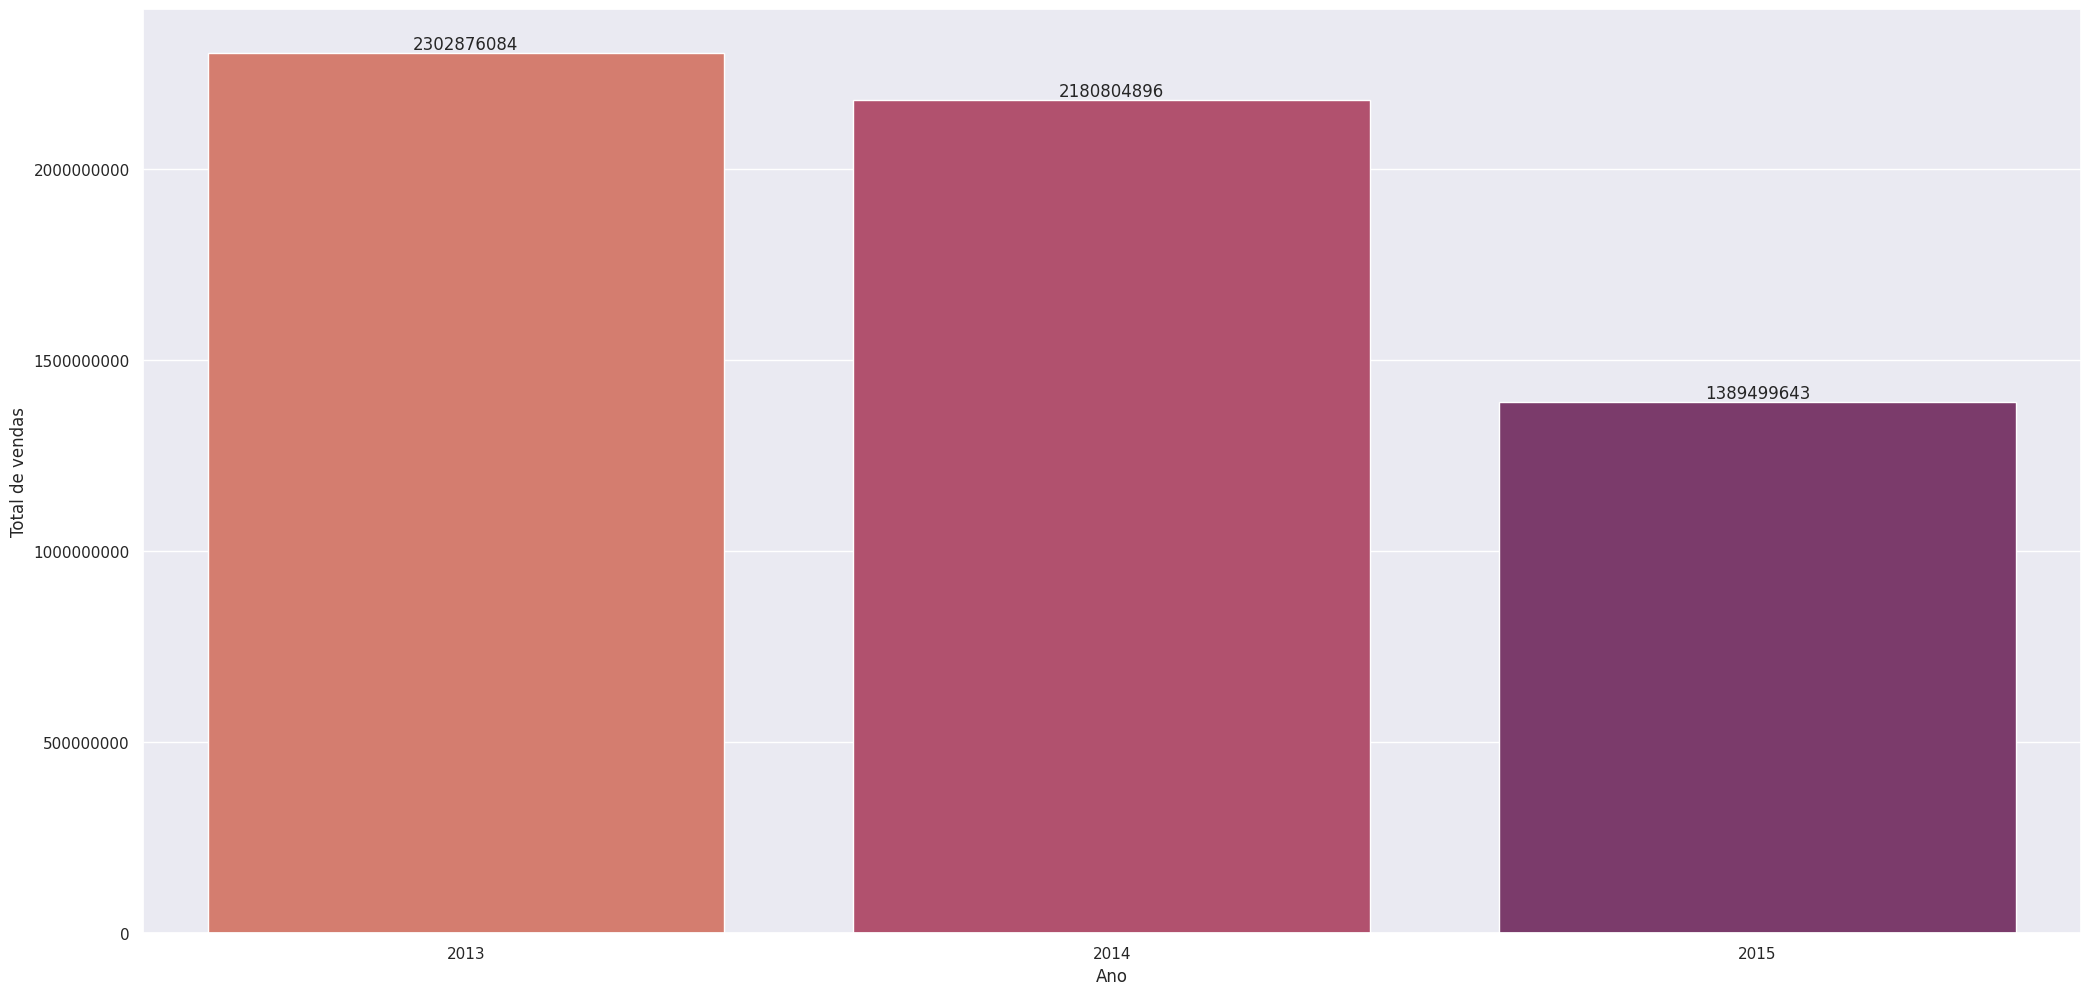

In [223]:

year_sales = df_in[['year', 'sales']].groupby('year').sum().reset_index().sort_values(by='sales', ascending=False)

# creating figure
# color_palette("flare")
f, ax = plt.subplots()
ax = sns.barplot(data=year_sales, x= 'year', y='sales', palette= 'flare')
ax.ticklabel_format(style='plain', axis="y")
ax.bar_label(ax.containers[0], fmt='%d')
ax.set( xlabel = 'Ano',ylabel='Total de vendas');


**Média de vendas por mês**

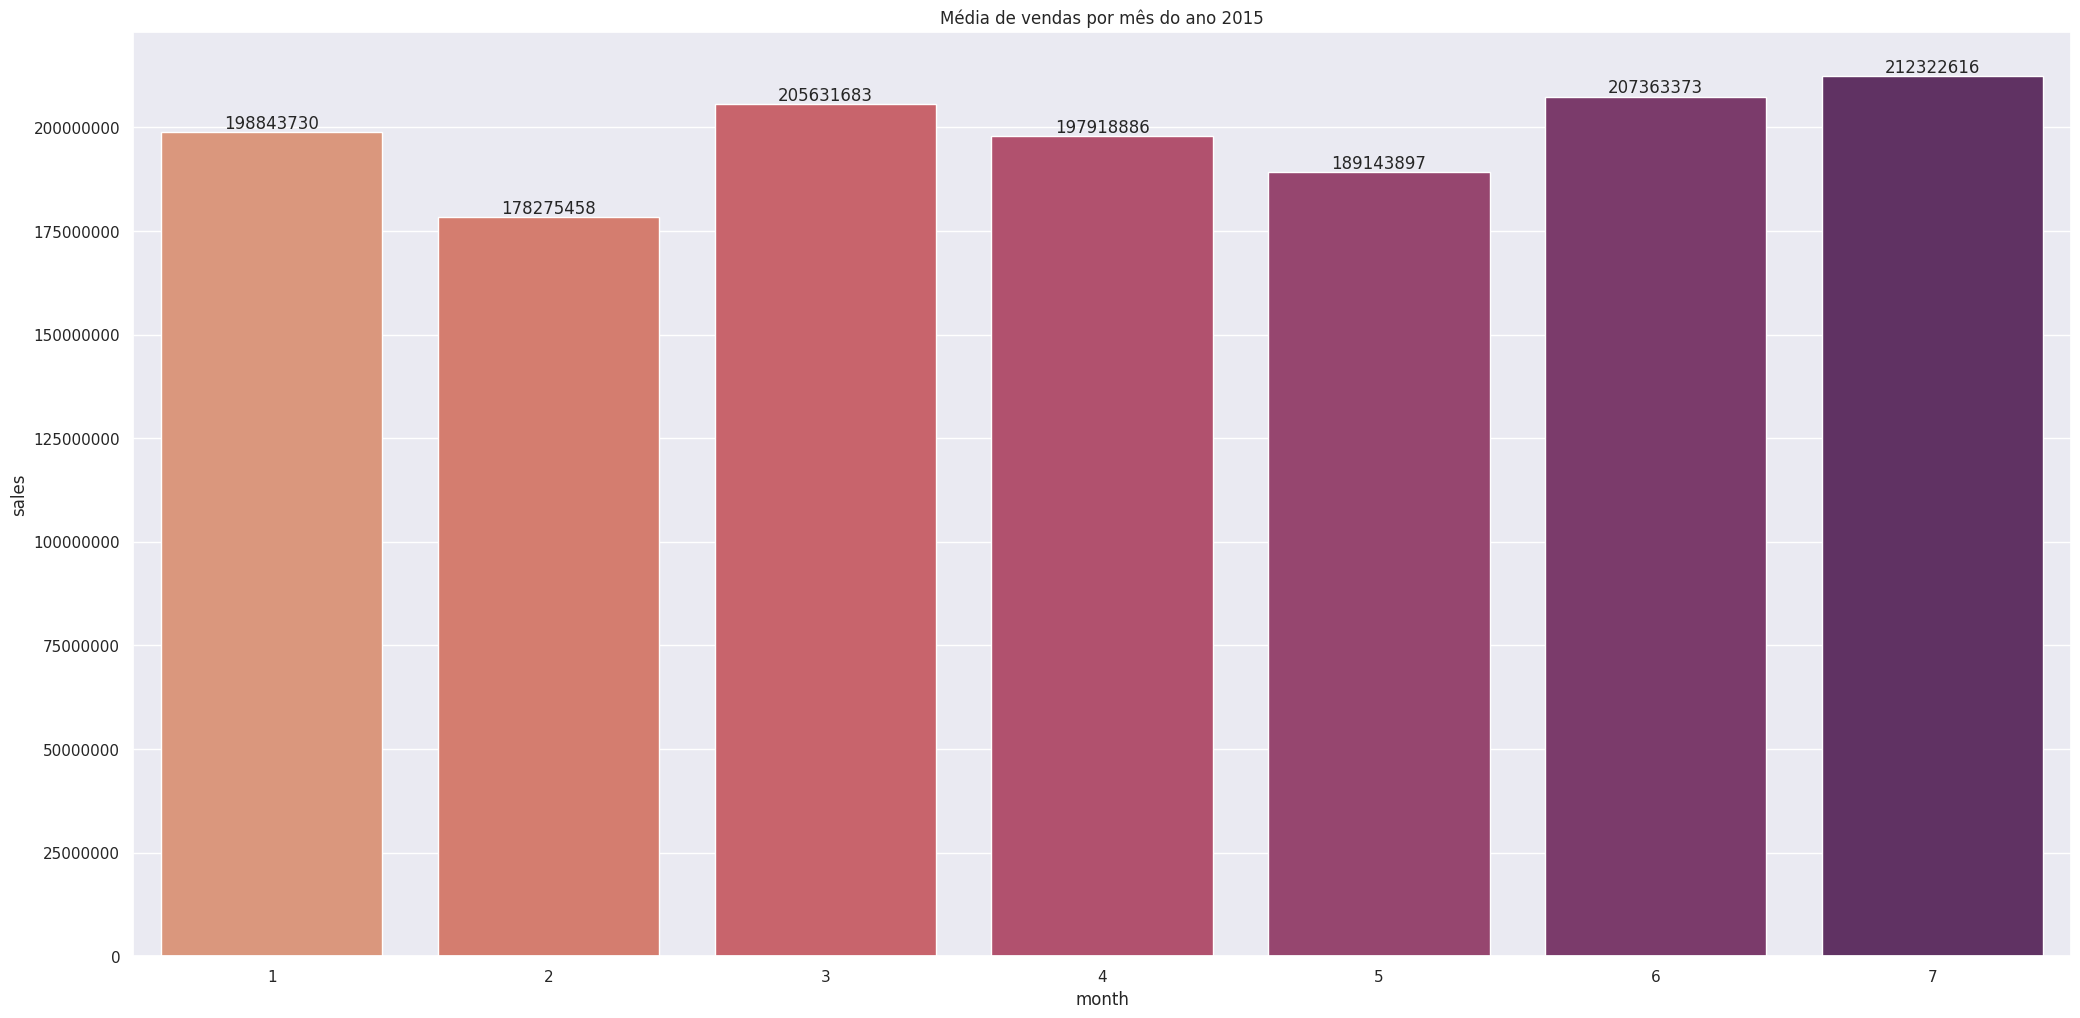

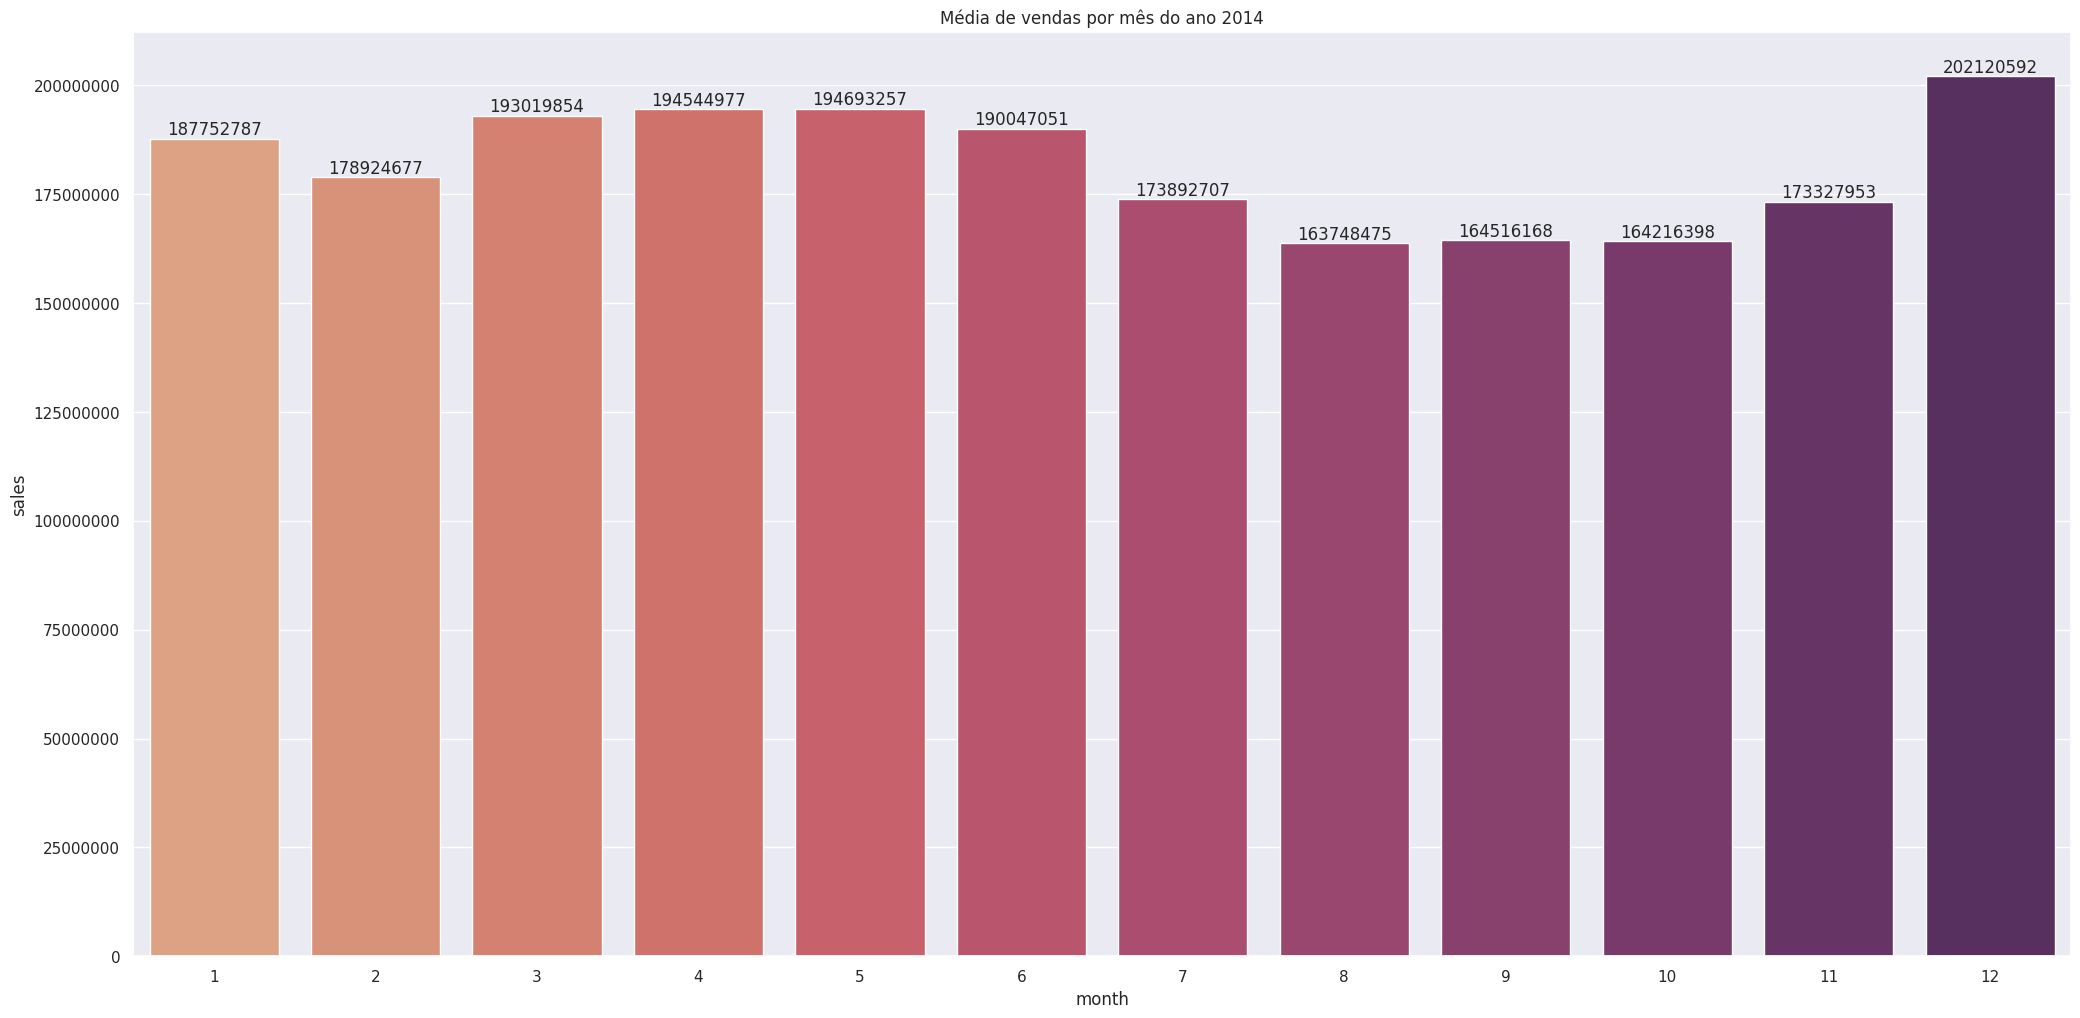

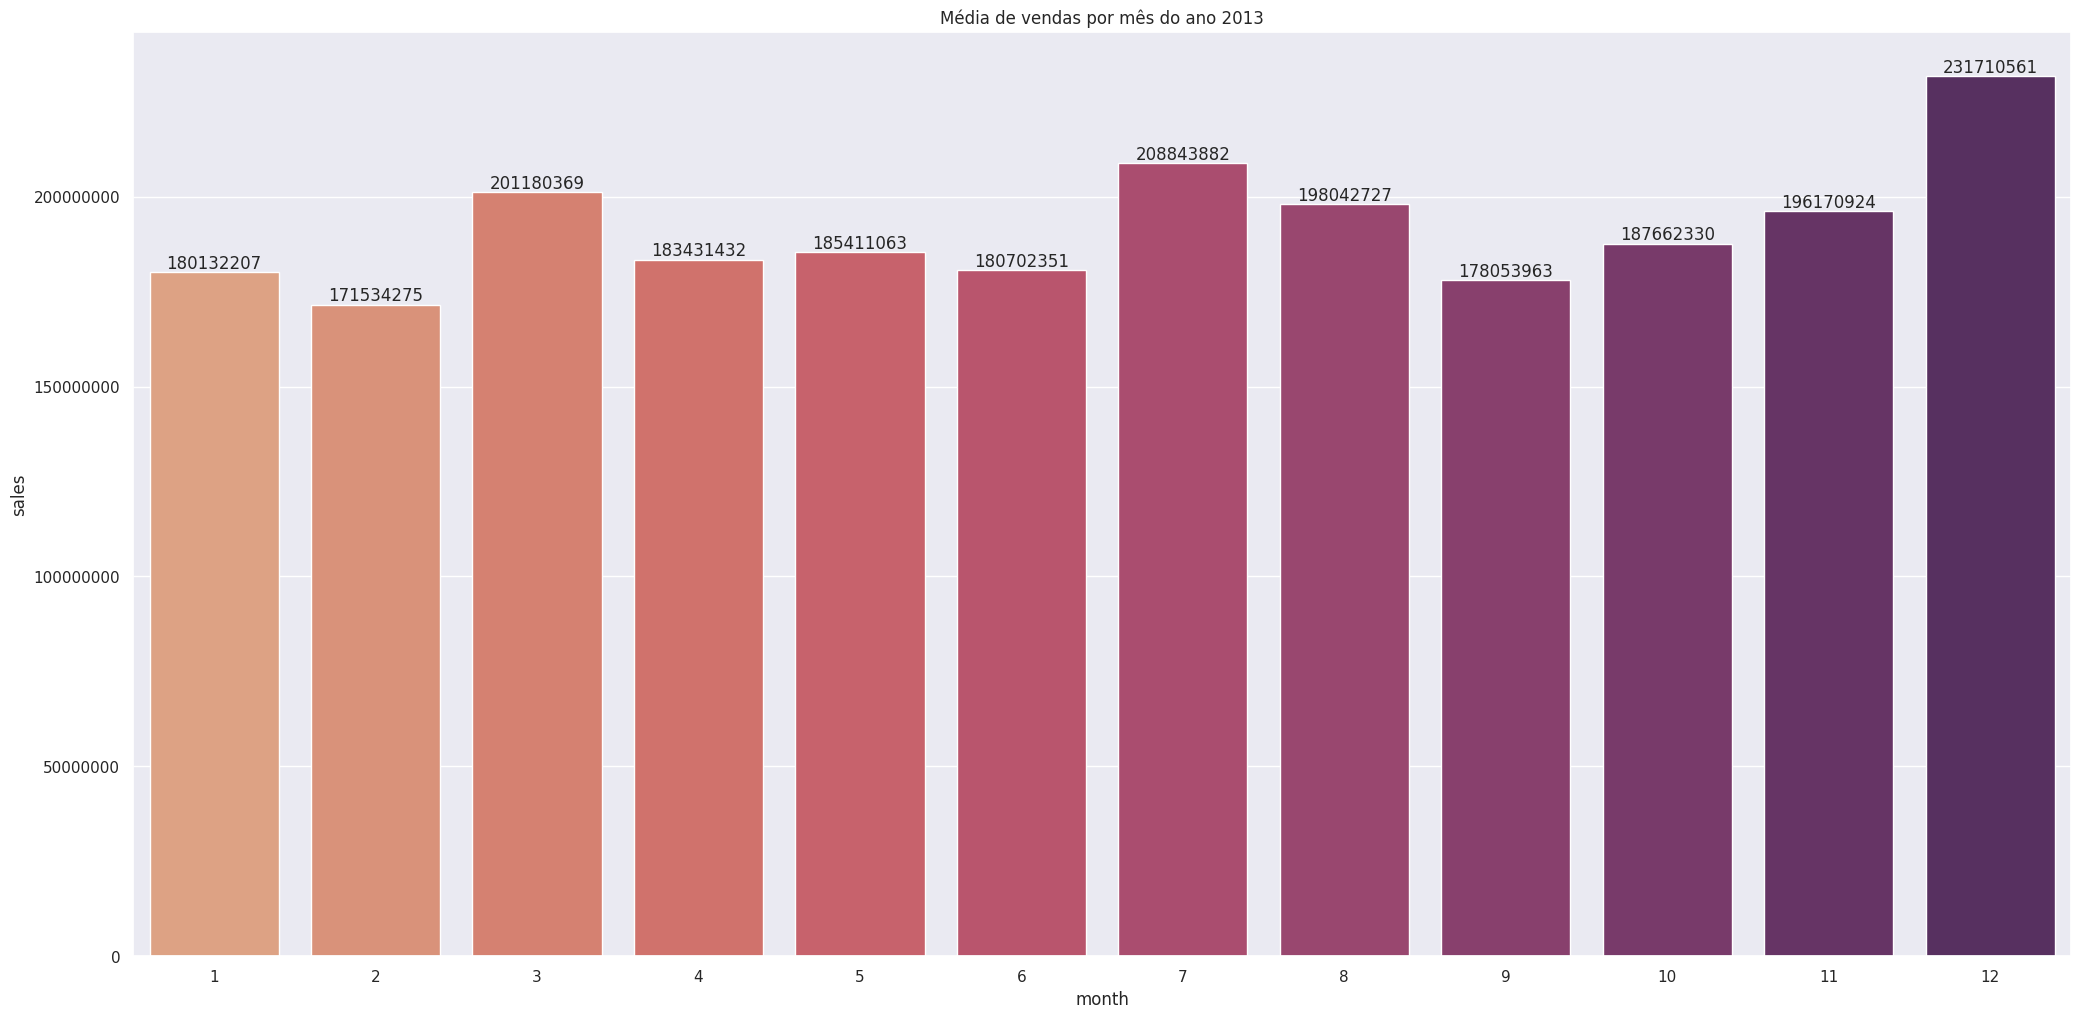

In [68]:
anos = list(df_in['year'].unique())

for i in anos:
    year_sales = df_in.loc[df_in['year'] == i ,['month', 'sales']].groupby('month').sum().reset_index().sort_values(by='sales', ascending=False) 
    # creating figure
    # color_palette("flare")
    f, ax = plt.subplots()
    ax = sns.barplot(data=year_sales, x= 'month', y='sales', palette= 'flare')
    ax.ticklabel_format(style='plain', axis="y")
    ax.bar_label(ax.containers[0], fmt='%d');
    plt.title(f'Média de vendas por mês do ano {i}')

**Média de vendas nos feriados**

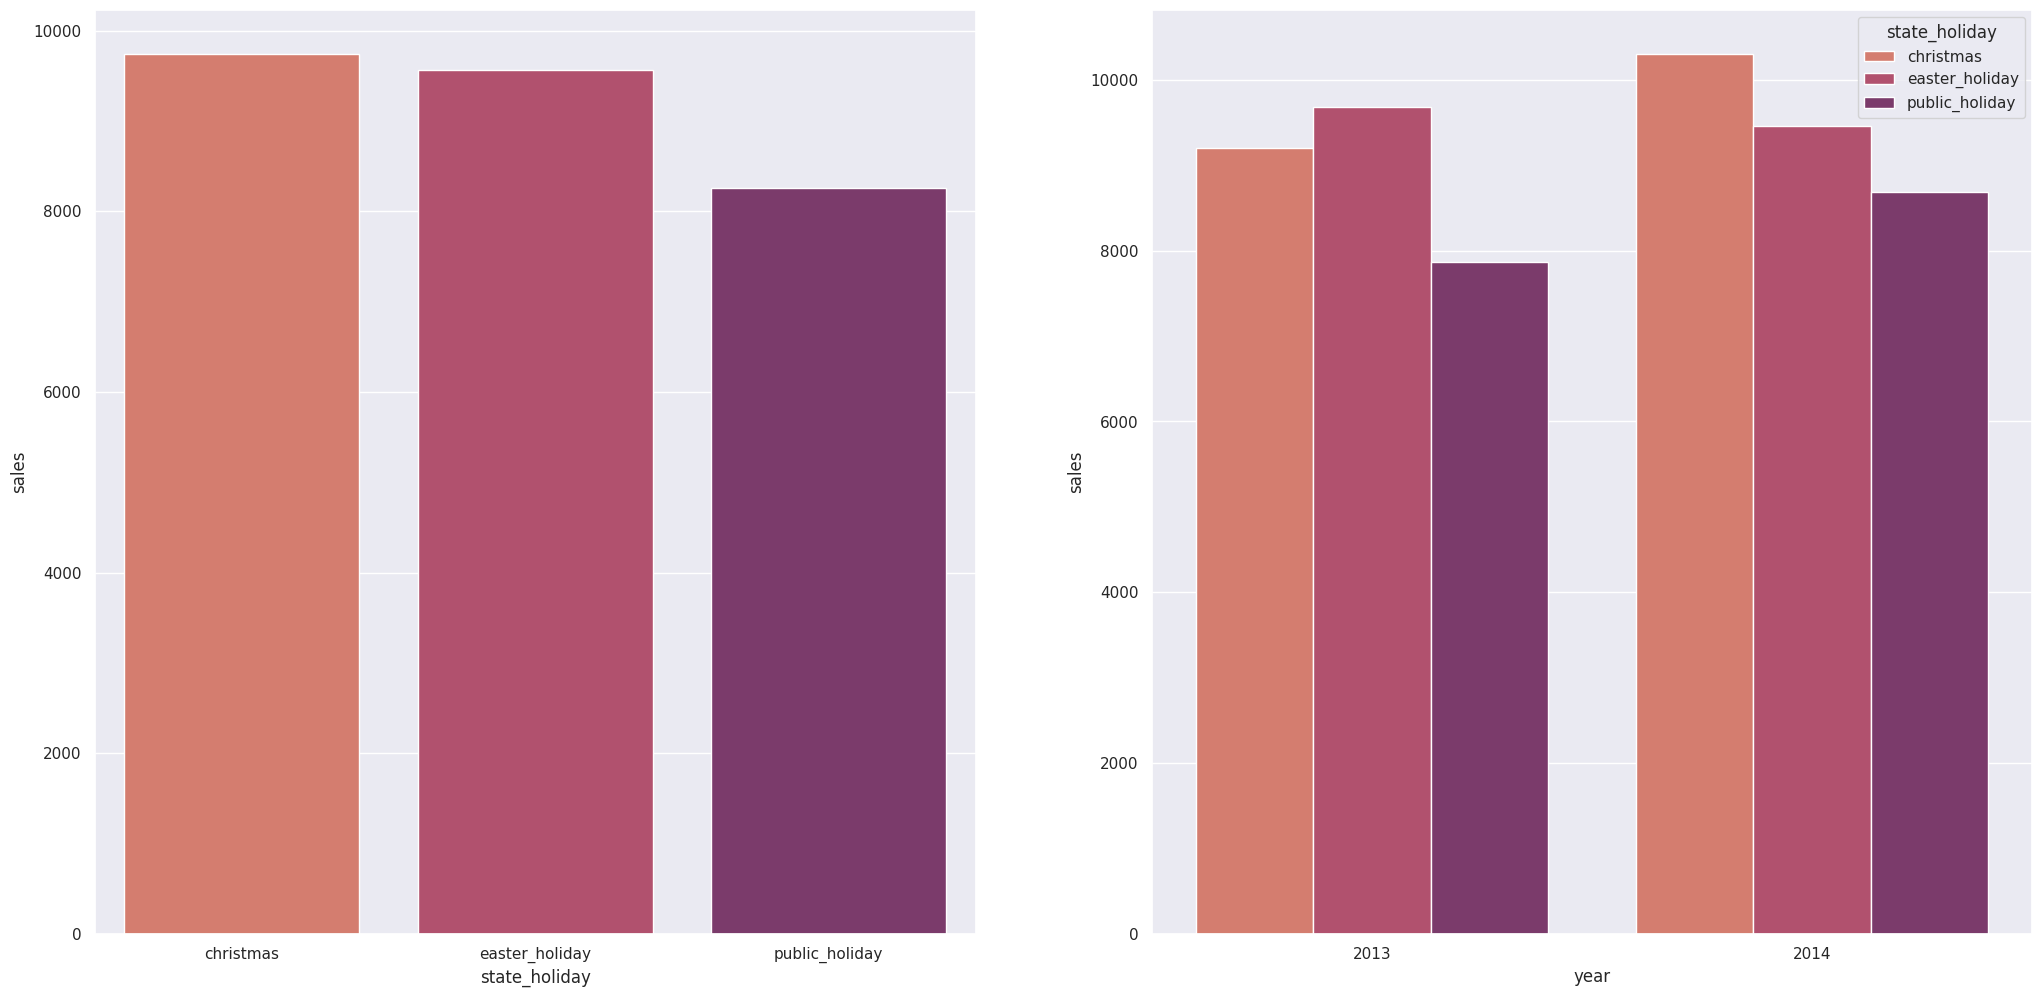

In [106]:
aux = df_in[(df_in['state_holiday'] != 'regular_day') & (df_in['year'] != 2015)]

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, palette= 'flare')

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()

sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2, palette= 'flare');

**Gráfico de donouts do assortment**

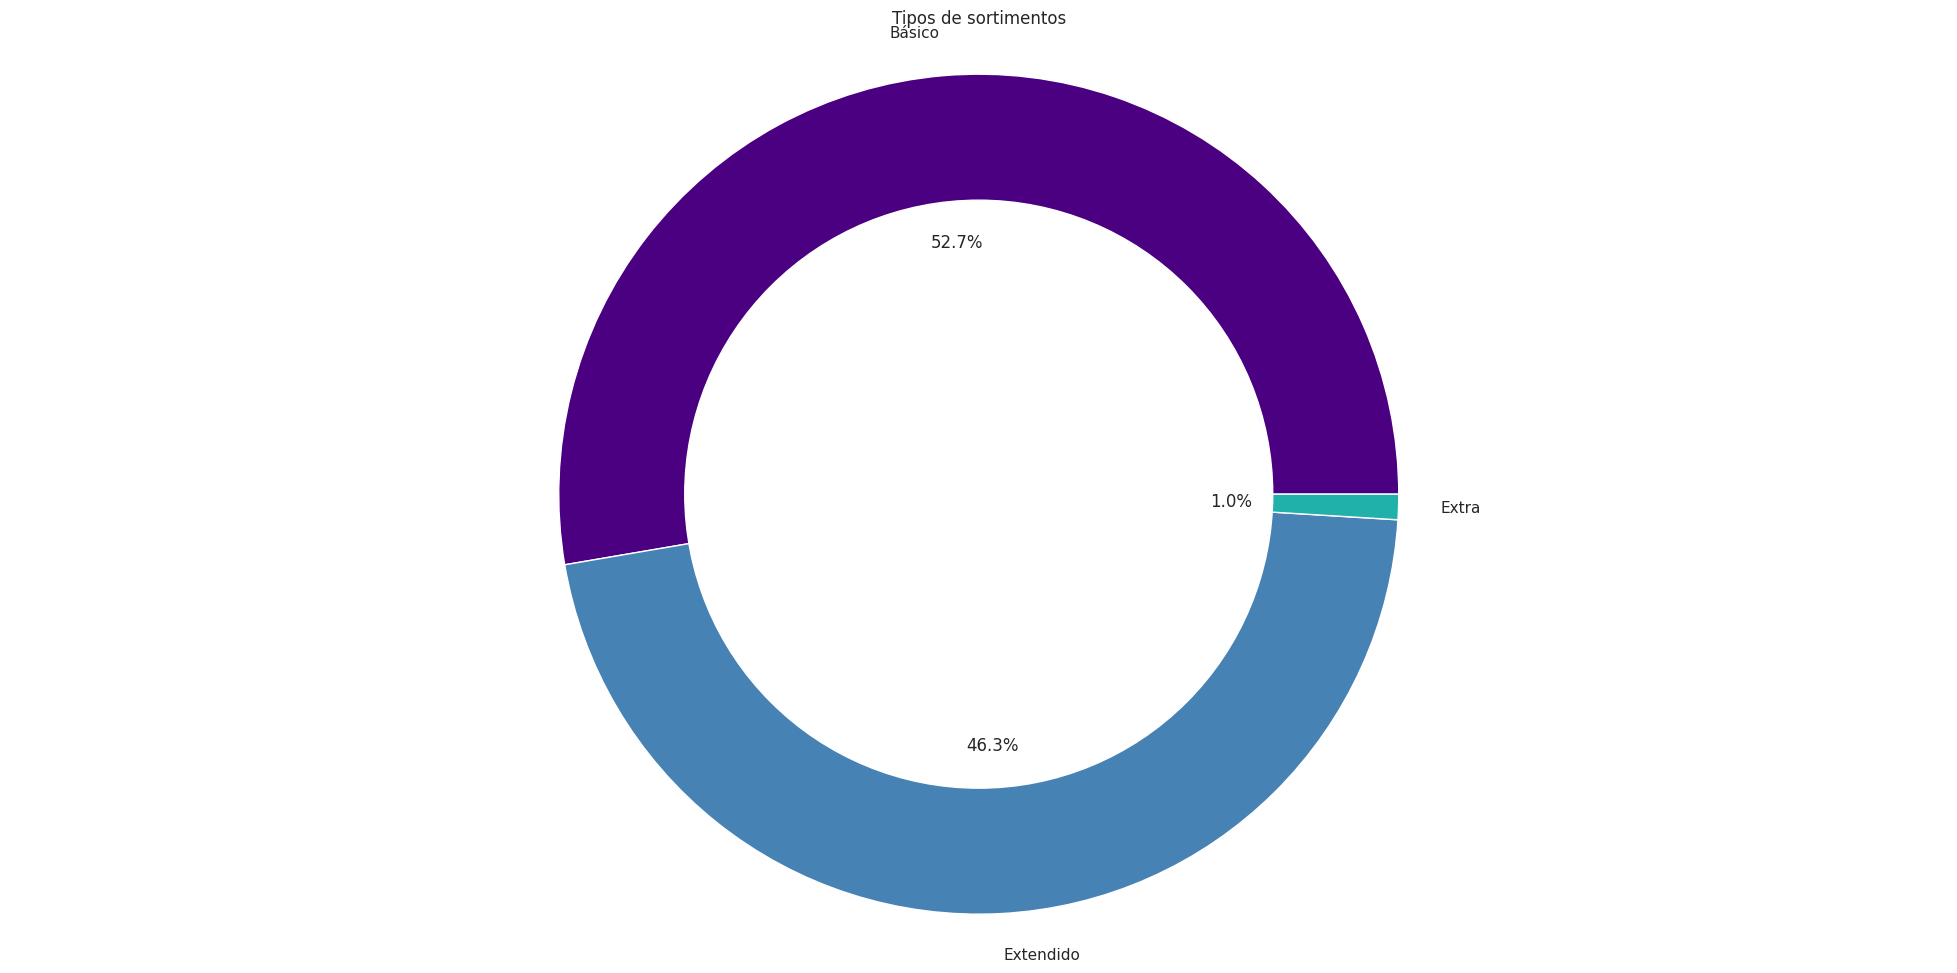

In [200]:
df_plot = df_in[['assortment', 'store']].groupby('assortment').count().reset_index()

legenda = {'basic': 'Básico', 'extended': 'Extendido', 'extra': 'Extra'}
df_plot['assortment'] = df_plot['assortment'].map(legenda)



    
labels = df_plot['assortment']
size = df_plot['store']
colors = ['indigo', 'steelblue', 'lightseagreen']

plt.pie(size, labels=labels, autopct= '%1.1f%%', colors=colors)

circle = plt.Circle((0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)


plt.title('Tipos de sortimentos')
plt.axis('equal')
plt.show();

**Graficos de média de vendas por assortmet**

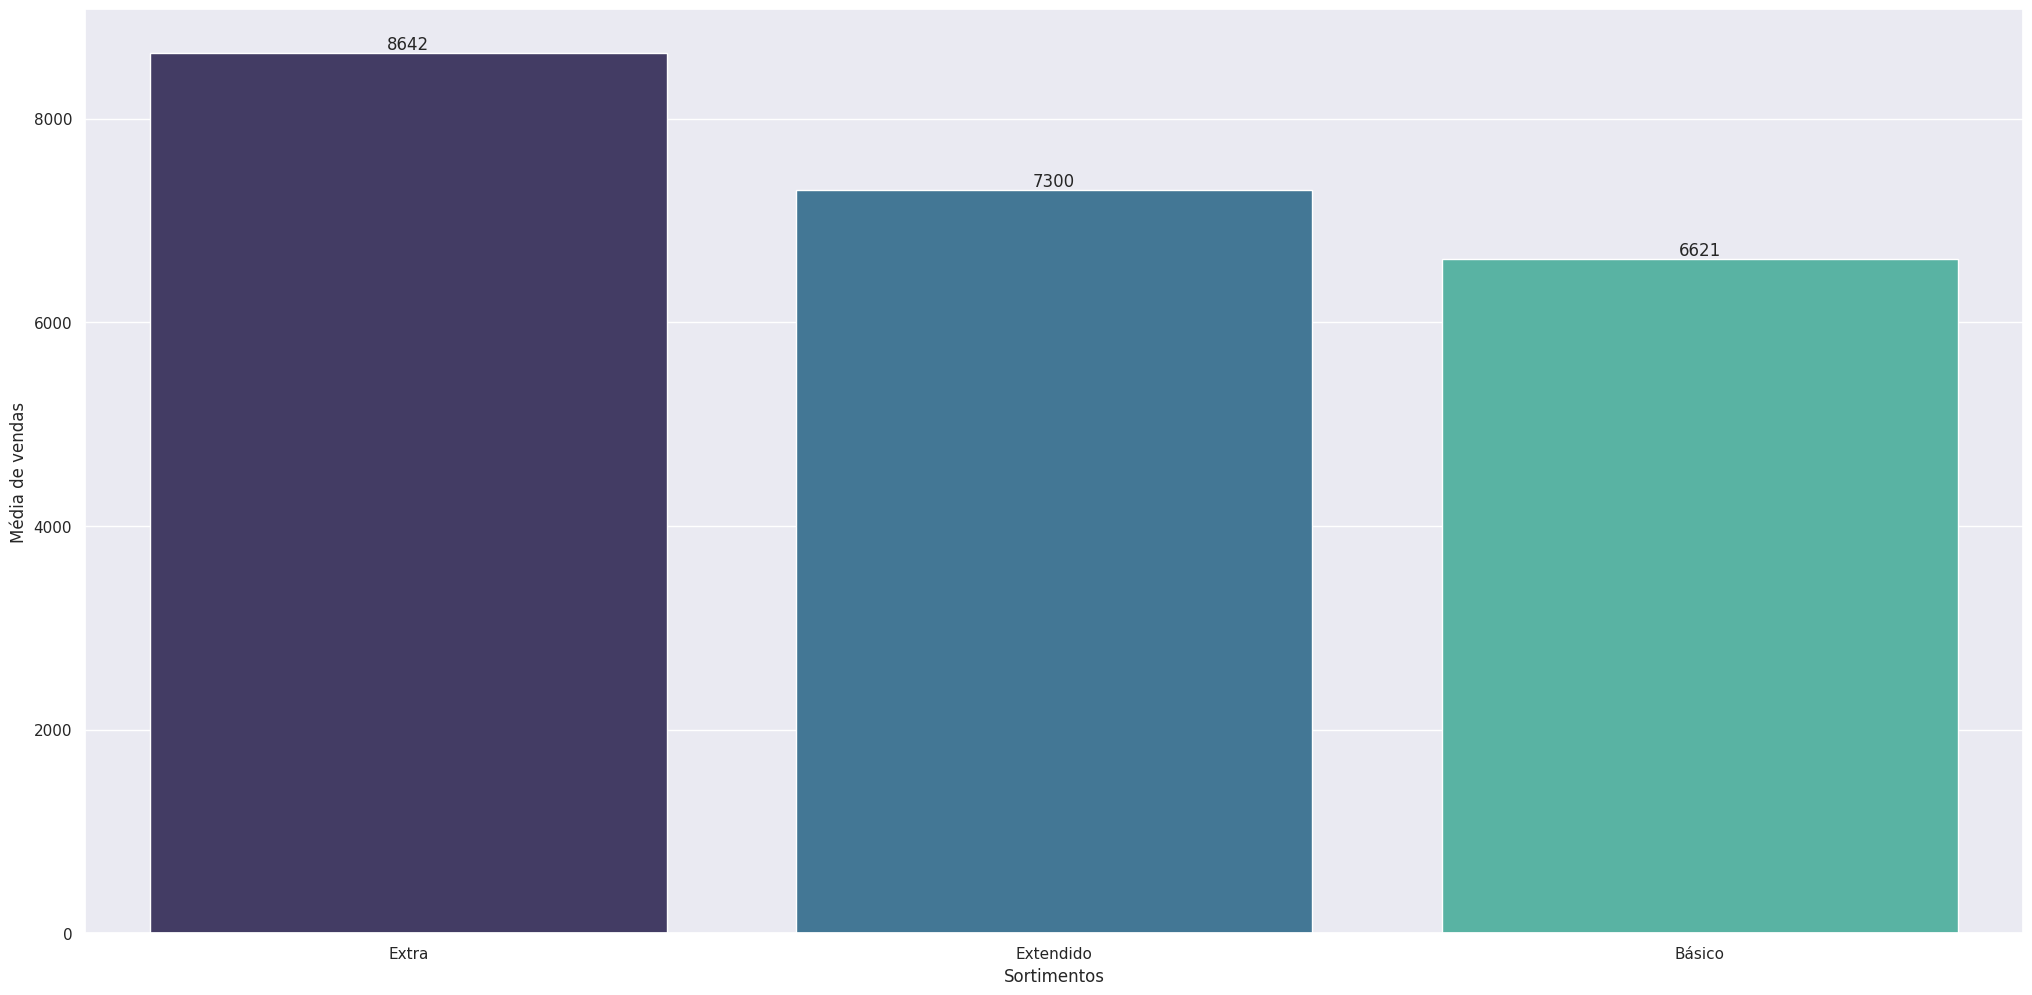

In [203]:
df_plot = df_in[['sales', 'assortment']].groupby('assortment').mean().reset_index().sort_values(by='sales', ascending= False)
legenda = {'basic': 'Básico', 'extended': 'Extendido', 'extra': 'Extra'}
df_plot['assortment'] = df_plot['assortment'].map(legenda)

ax = sns.barplot(data=df_plot,y= 'sales', x='assortment', palette= 'mako');
ax.bar_label(ax.containers[0], fmt='%d');
ax.set(xlabel='Sortimentos', ylabel='Média de vendas');

**Análise de promoções**

Total de vendas em lojas com promoções - filtrar por ano

In [210]:
df_plot = df_in.loc[df_in['is_promo'] != 0, ['sales', 'year']]
df_plot['sales'].sum()

942804600

In [211]:
anos = list(df_plot['year'].unique())
anos

for i in anos:
    x = df_plot.loc[df_plot['year'] == i, 'sales'].sum()
    print(x, i)

250240314 2015
325557287 2014
367006999 2013


Gráfico de média de vendas de lojas com promoção e sem promoção

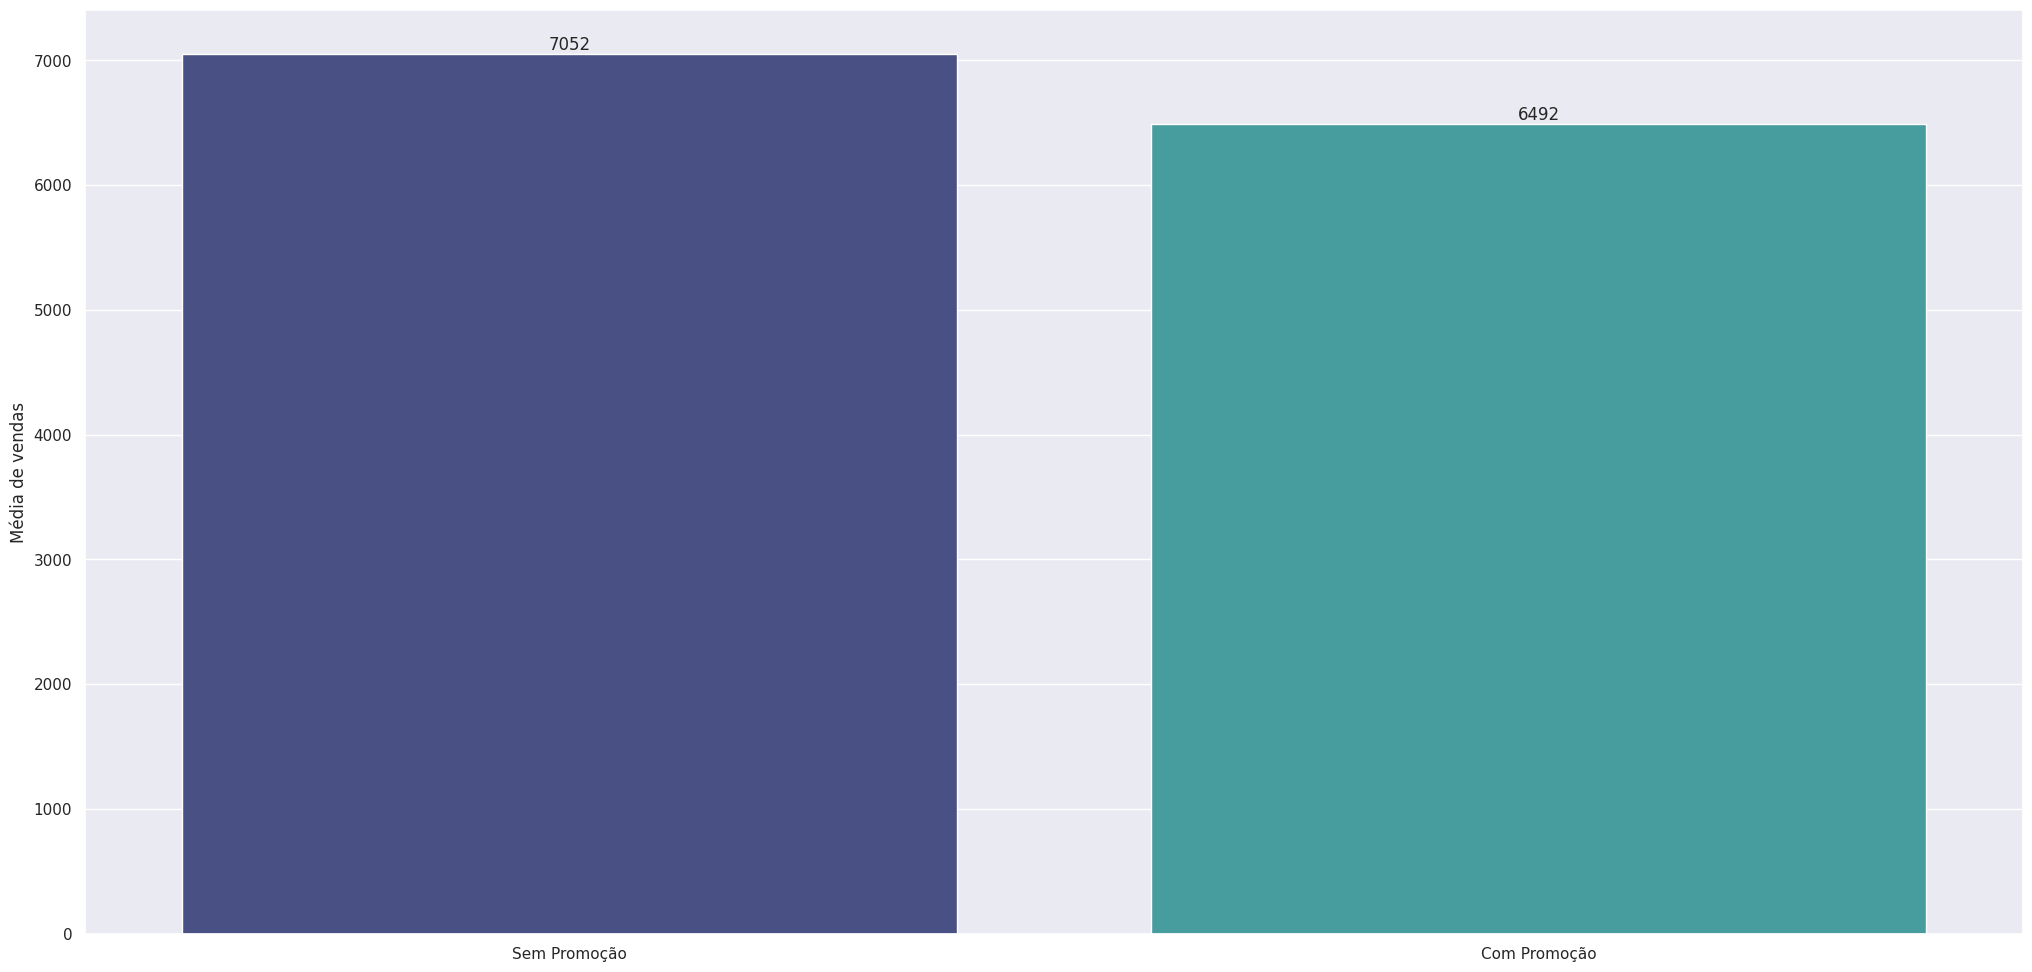

In [217]:
df_plot = df_in[['is_promo','sales']].groupby('is_promo').mean().reset_index()
legenda = {0: 'Sem Promoção', 1: 'Com Promoção'}
df_plot['is_promo'] = df_plot['is_promo'].map(legenda)

ax = sns.barplot(data=df_plot,y= 'sales', x='is_promo', palette= 'mako');
ax.bar_label(ax.containers[0], fmt='%d');
ax.set( xlabel = '',ylabel='Média de vendas');

In [ ]:
df_plot = df_in[['sales', 'assortment']].groupby('assortment').mean().reset_index().sort_values(by='sales', ascending= False)
legenda = {'basic': 'Básico', 'extended': 'Extendido', 'extra': 'Extra'}
df_plot['assortment'] = df_plot['assortment'].map(legenda)

ax = sns.barplot(data=df_plot,y= 'sales', x='assortment', palette= 'mako');
ax.bar_label(ax.containers[0], fmt='%d');
ax.set(xlabel='Sortimentos', ylabel='Média de vendas');